<a href="https://colab.research.google.com/github/mgiorgi13/GNN_Notebooks/blob/main/Graph%20Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [12]:
#Colab
# from google.colab import drive
# drive.mount('/content/drive')
# GNN_PATH = '/content/drive/MyDrive/Colab Notebooks/GNN/'

#Local
GNN_PATH = './GNN/'
import os
if not os.path.exists(GNN_PATH):
    os.makedirs(GNN_PATH)

In [13]:
# Install packages
%pip install torch torch-geometric scikit-learn pandas shapely seaborn pygmtools numpy moviepy matplotlib optuna tensorboard
#check if pygmtools is installed
try:
    import pygmtools
except ImportError:#pygmtools library
    %pip install git+https://github.com/Thinklab-SJTU/pygmtools.git

# Check pytorch version and make sure you use a GPU Kernel
import torch
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
!nvcc --version
# Check GPU
!nvidia-smi

#set device as cuda if available to load model and data on gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Note: you may need to restart the kernel to use updated packages.
PyTorch version: 2.2.2
CUDA version: None
zsh:1: command not found: nvcc
zsh:1: command not found: nvidia-smi


In [14]:
# ─── Standard library ──────────────────────────────────────────────────────────
import copy
import os
import sys
import pickle
import random
import time
import math
from pathlib import Path
from typing import List, Tuple, Dict, Any
from datetime import datetime

# ─── Third-party libraries ─────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.affinity import translate
from shapely.geometry import Polygon
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


from torch_geometric.data import Data, Batch
from torch_geometric.nn import GATv2Conv, GCNConv

from moviepy.editor import ImageSequenceClip
import optuna
import json

# ─── Local application/library imports ────────────────────────────────────────
import pygmtools
pygmtools.BACKEND = 'pytorch'

destination_dir = os.path.join('AFAT')

# Ensure the destination directory is in sys.path
if destination_dir not in sys.path:
    sys.path.append(destination_dir)

# AFA-U inlier predictor and Top-K matching from AFAT
from k_pred_net import Encoder as AFAUEncoder
from sinkhorn_topk import soft_topk

In [15]:
# Set Seed for reproducibility
seed = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ['PYTHONHASHSEED'] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed once at the beginning
set_seed(seed)

# For reproducible DataLoader shuffle
g = torch.Generator()
g.manual_seed(seed)

# Utilities

## Dataset

In [22]:
#----------------------------------------
#            DATASET UTILS
#----------------------------------------

def deserialize_MSD_dataset(data_path, original_path=None, noise_path=None, dimensions_path=None):
    dataset_dir = Path(data_path)

    dimensions = []
    if dimensions_path is not None:
        # Load dimensions
        dimensions_file = dataset_dir / f"{dimensions_path}.pickle"
        if not dimensions_file.exists():
            raise FileNotFoundError(f"Dimensions file not found at {dimensions_file}")
        with open(dimensions_file, 'rb') as f:
            dimensions = pickle.load(f)

    # Clear existing graphs
    original = []
    noise = []

    if original_path is not None:
        original_dir = dataset_dir / original_path
        original_files = sorted(original_dir.glob("*.pt"), key=lambda f: int(f.stem))
        print(f"Loading {len(original_files)} original graphs...")
        for file in tqdm(original_files, desc="Original graphs"):
            with open(str(file), "rb") as f:
                graph = pickle.load(f)
                graph.graph['name'] = file.stem
            original.append(graph)

    if noise_path is not None:
        def extract_numeric_key(file):
            """Extracts (X, Y) from filenames like 'X_Y.pt' for proper numeric sorting."""
            name_parts = file.stem.split("_")
            return int(name_parts[0]), int(name_parts[1])

        noise_dir = dataset_dir / noise_path
        noise_files = sorted(noise_dir.glob("*.pt"), key=extract_numeric_key)
        print(f"Loading {len(noise_files)} noise graphs...")
        for file in tqdm(noise_files, desc="Noise graphs"):
            with open(str(file), "rb") as f:
                graph = pickle.load(f)
                graph.graph['name'] = file.stem
            noise.append(graph)

    return original, noise, dimensions

def serialize_graph_matching_dataset(pairs: List[Tuple[Data, Data, torch.Tensor]], path: str, filename: str = "train_dataset.pkl"):
    """
    Serialize a list of (Data1, Data2, PermutationMatrix) tuples to a file.
    """
    os.makedirs(path, exist_ok=True)
    full_path = os.path.join(path, filename)

    with open(full_path, 'wb') as f:
        pickle.dump(pairs, f)

    print(f"Serialized {len(pairs)} pairs to {full_path}")

def deserialize_graph_matching_dataset(path: str, filename: str = "train_dataset.pkl") -> List[Tuple[Data, Data, torch.Tensor]]:
    """
    Deserialize a dataset of (Data1, Data2, PermutationMatrix) tuples from a file.
    """
    full_path = os.path.join(path, filename)

    if not os.path.exists(full_path):
        raise FileNotFoundError(f"File not found: {full_path}")

    with open(full_path, 'rb') as f:
        pairs = pickle.load(f)

    print(f"Loaded {len(pairs)} pairs from {full_path}")
    return pairs

def plot_a_graph(graphs_list, path=None, viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=False, viz_walls=True):
    """
    Visualizes geometries, wall segments, and graph edges for multiple apartments in 2D.

    Parameters:
    graphs_list (list of networkx.Graph): List of graphs with nodes ('type', 'center', 'normal') and edges for the apartments.
    viz_normals (bool): If True, plots wall segment normals.
    viz_rooms (bool): If True, displays room polygons.
    viz_ws (bool): If True, displays wall segments.
    viz_openings (bool): If True, displays openings (doors and windows).
    viz_wall_edges (bool): If True, displays edges between wall segments.
    viz_connection_edges (bool): If True, displays edges connecting rooms via openings.
    viz_walls (bool): If True, displays wall nodes and their edges.
    """
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
    legend_added = False  # Flag to ensure the legend is added only once
    normal_added = False  # Flag to ensure the "Normal" label is added only once

    for graphs in graphs_list:
        # Visualize room polygons
        if viz_rooms:
            room_nodes = [n for n, d in graphs.nodes(data=True) if d['type'] == 'room']
            for idx, room_node in enumerate(room_nodes):
                room_data = graphs.nodes[room_node]
                # Plot the polygon
                room_polygon = Polygon(room_data['polygon'])
                x, y = room_polygon.exterior.xy
                ax.plot(x, y, color='black', alpha=0.2, label='Room polygon' if not legend_added and idx == 0 else "")
                # Draw room centroids
                ax.scatter(room_data['center'][0], room_data['center'][1], color='blue', s=100, label='Room centroid' if not legend_added and idx == 0 else "")

        # Visualize wall nodes and edges
        if viz_walls:
            wall_nodes = [n for n, d in graphs.nodes(data=True) if d['type'] == 'wall']
            for idx, wn in enumerate(wall_nodes):
                wall_data = graphs.nodes[wn]
                # Plot the polygon of the wall
                wall_polygon = Polygon(wall_data['polygon'])
                x, y = wall_polygon.exterior.xy
                ax.plot(x, y, color='purple', linestyle='-', label='Wall polygon' if not legend_added and idx == 0 else "")
                ax.scatter(wall_data['center'][0], wall_data['center'][1], color='purple', s=50, label='Wall centroid' if not legend_added and idx == 0 else "")

            if viz_normals:
                wall_ws = [n for n, d in graphs.nodes(data=True) if d['type'] == 'wall_ws']
                for idx, wn in enumerate(wall_ws):
                    ws_data = graphs.nodes[wn]
                    ax.scatter(ws_data['center'][0], ws_data['center'][1], color='purple', s=20, label='Wall ws' if not legend_added and idx == 0 else "")
                    ax.arrow(ws_data['center'][0], ws_data['center'][1],
                             ws_data['normal'][0], ws_data['normal'][1],
                             head_width=0.1, head_length=0.1, fc='green', ec='green', label='Normal' if not normal_added else "")
                    normal_added = True

            wall_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'wall' in u or 'wall' in v]
            for idx, edge in enumerate(wall_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                        [start_node['center'][1], end_node['center'][1]],
                        color='purple', linestyle='--', label='Wall edge' if not legend_added and idx == 0 else "")

        # Visualize openings
        if viz_openings:
            opening_nodes = [n for n, d in graphs.nodes(data=True) if 'door' in d['type'] or 'window' in d['type']]
            for idx, on in enumerate(opening_nodes):
                opening_data = graphs.nodes[on]
                opening_polygon = Polygon(opening_data['polygon'])
                x, y = opening_polygon.exterior.xy
                ax.plot(x, y, color='orange', label='Opening polygon' if not legend_added and idx == 0 else "")
                # Draw opening centroids
                ax.scatter(opening_data['center'][0], opening_data['center'][1], color='orange', s=10, label='Opening centroid' if not legend_added and idx == 0 else "")

            if viz_normals:
                opening_ws = [n for n, d in graphs.nodes(data=True) if d['type'] == 'door_ws' or d['type'] == 'window_ws']
                for idx, wn in enumerate(opening_ws):
                    ws_data = graphs.nodes[wn]
                    ax.scatter(ws_data['center'][0], ws_data['center'][1], color='orange', s=10, label='Opening ws' if not legend_added and idx == 0 else "")
                    ax.arrow(ws_data['center'][0], ws_data['center'][1],
                             ws_data['normal'][0], ws_data['normal'][1],
                             head_width=0.1, head_length=0.1, fc='green', ec='green', label='Normal' if not normal_added else "")
                    normal_added = True

            # Draw opening edges
            open_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'door' in u or 'window' in v or 'door' in v or 'window' in u]
            for idx, edge in enumerate(open_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                        [start_node['center'][1], end_node['center'][1]],
                        color='orange', linestyle='--', label='Opening edge' if not legend_added and idx == 0 else "")

        # Visualize ws room
        if viz_ws:
            ws_nodes = [n for n, d in graphs.nodes(data=True) if d['type'] == 'ws']
            for idx, wn in enumerate(ws_nodes):
                ws_data = graphs.nodes[wn]
                ax.scatter(ws_data['center'][0], ws_data['center'][1], color='red', s=20, label='Ws segment' if not legend_added and idx == 0 else "")
                if viz_room_normals:
                    ax.arrow(ws_data['center'][0], ws_data['center'][1],
                             ws_data['normal'][0], ws_data['normal'][1],
                             head_width=0.1, head_length=0.1, fc='green', ec='green', label='Normal' if not normal_added else "")
                    normal_added = True
                if 'limits' in ws_data:
                    limit_1, limit_2 = ws_data['limits']
                    ax.plot([limit_1[0], limit_2[0]],
                            [limit_1[1], limit_2[1]],
                            color='black', linewidth=1.0,
                            label='Ws limits' if idx == 0 else "")
            ws_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'ws_same_room' in d['type'] or 'ws_belongs_room' in d['type']]
            for idx, edge in enumerate(ws_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                    [start_node['center'][1], end_node['center'][1]],
                    color='gray', linestyle='--', label='Ws edge' if not legend_added and idx == 0 else "")

        # Visualize connection edges
        if viz_room_connection:
            connection_edges = [(u, v) for u, v, d in graphs.edges(data=True) if 'connected' in d['type']]
            for idx, edge in enumerate(connection_edges):
                start_node = graphs.nodes[edge[0]]
                end_node = graphs.nodes[edge[1]]
                ax.plot([start_node['center'][0], end_node['center'][0]],
                        [start_node['center'][1], end_node['center'][1]],
                        color='blue', linestyle='-', label='Connection edge' if not legend_added and idx == 0 else "")

        legend_added = True  # Set the flag to True after processing the first graph

    plt.title("Apartment Graph Visualization")
    plt.legend()
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close()

node_type_mapping = {"room": [1, 0], "ws": [0, 1]}

def pyg_data_to_nx_digraph(data: Data, graph_list: List[nx.DiGraph]) -> nx.DiGraph:
    """
    Convert a PyTorch Geometric Data object back to a NetworkX DiGraph,
    restoring original node IDs using data.node_names and data.permutation,
    matching with the graph in graph_list that has the same name.
    """
    assert hasattr(data, 'node_names'), \
        "Data object must contain 'node_names' to restore original node IDs."
    assert hasattr(data, 'permutation'), \
        "Data object must contain 'permutation' to reorder nodes."
    assert hasattr(data, 'name'), \
        "Data object must contain 'name' to match with graph_list."

    matching_graph = next((g for g in graph_list if g.graph.get('name') == data.name), None)
    if matching_graph is None:
        raise ValueError(f"No graph with name {data.name} found in graph_list.")

    orig_names = data.node_names
    perm = data.permutation.tolist()
    node_ids = [orig_names[idx] for idx in perm]

    G = nx.DiGraph()
    for node_id in node_ids:
        if node_id in matching_graph.nodes:
            G.add_node(node_id, **matching_graph.nodes[node_id])

    for u_idx, v_idx in data.edge_index.t().tolist():
        u = node_ids[u_idx]
        v = node_ids[v_idx]
        if matching_graph.has_edge(u, v):
            G.add_edge(u, v, **matching_graph.edges[u, v])

    G.graph['name'] = data.name
    return G


def nx_to_pyg_data_preserve_order(graph: nx.DiGraph) -> Data:
    """
    Convert a NetworkX DiGraph to a PyTorch Geometric Data object,
    preserving node insertion order, storing 'node_names' and an identity 'permutation'.
    """
    node_ids = list(graph.nodes())
    id_map = {nid: i for i, nid in enumerate(node_ids)}

    x = torch.stack([
        torch.tensor(
            node_type_mapping[graph.nodes[n]['type']] +
            graph.nodes[n]['center'] +
            graph.nodes[n]['normal'] +
            [graph.nodes[n].get('length', -1)],
            dtype=torch.float32
        )
        for n in node_ids
    ])

    edge_index = torch.tensor(
        [[id_map[u], id_map[v]] for u, v in graph.edges()],
        dtype=torch.long
    ).t().contiguous() if graph.edges else torch.empty((2, 0), dtype=torch.long)

    data = Data(x=x, edge_index=edge_index)
    data.name = graph.graph.get('name')
    data.node_names = node_ids
    data.permutation = torch.arange(len(node_ids), dtype=torch.long)
    return data

def split_graphs_stratified(
    pairs: List[Tuple[Data, Data, torch.Tensor]],
    train_frac: float = 0.7,
    val_frac: float   = 0.15,
    test_frac: float  = 0.15,
    n_bins: int       = 5,
    seed: int         = seed,
    stratify_on: str  = "g2"     # "g1" oppure "g2"
) -> Tuple[
    List[Tuple[Data,Data,torch.Tensor]],
    List[Tuple[Data,Data,torch.Tensor]],
    List[Tuple[Data,Data,torch.Tensor]]
]:
    """
    Stratified split of graph-matching pairs into train/val/test.
    Puoi stratificare sulla dimensione di g1 o di g2.
    """
    assert stratify_on in ("g1","g2"), "stratify_on must be 'g1' or 'g2'"
    total = train_frac + val_frac + test_frac
    assert abs(total - 1.0) < 1e-6, "train+val+test fractions must sum to 1.0"

    # scegli la dimensione su cui stratificare
    if stratify_on == "g1":
        sizes = np.array([g1.num_nodes for g1, g2, P in pairs])
    else:
        sizes = np.array([g2.num_nodes for g1, g2, P in pairs])

    # quantile‑binning per equal‑frequency
    while n_bins > 1:
        try:
            size_bins = pd.qcut(sizes, q=n_bins, labels=False, duplicates="drop")
        except ValueError:
            n_bins -= 1
            continue
        counts = np.bincount(size_bins, minlength=n_bins)
        if np.all(counts >= 2):
            break
        n_bins -= 1

    idx = np.arange(len(pairs))
    if n_bins <= 1:
        # fallback random split
        train_idx, temp_idx = train_test_split(idx, test_size=1-train_frac, random_state=seed)
        rel_val = val_frac/(val_frac+test_frac)
        val_idx, test_idx = train_test_split(temp_idx, test_size=1-rel_val, random_state=seed)
    else:
        train_idx, temp_idx = train_test_split(
            idx, test_size=(1.0-train_frac),
            random_state=seed, stratify=size_bins
        )
        rel_val = val_frac/(val_frac+test_frac)
        temp_bins = size_bins[temp_idx]
        val_idx, test_idx = train_test_split(
            temp_idx, test_size=(1.0-rel_val),
            random_state=seed, stratify=temp_bins
        )

    train = [pairs[i] for i in train_idx]
    val   = [pairs[i] for i in val_idx]
    test  = [pairs[i] for i in test_idx]
    return train, val, test

# Controllo rapido delle distribuzioni
def describe(split, name):
    sz = [g1.num_nodes for g1, _, _ in split]
    print(f"{name}: count={len(split)}, nodes min={min(sz)}, max={max(sz)}, mean={np.mean(sz):.1f}")

def generate_matching_pair_as_data(
    g1: nx.DiGraph,
    g2: nx.DiGraph,
    pairs_list: List[Tuple[Data, Data, torch.Tensor]]
) -> None:
    """
    Generate a matching pair for partial graph matching:
    - g1: complete graph (reference)
    - g2: partial graph to be permuted
    Stores (Data_g1, Data_g2_permuted, P) in pairs_list, where P is ground truth of shape [|g1|, |g2|].
    """
    # Convert reference graph
    pyg_g1 = nx_to_pyg_data_preserve_order(g1)

    # Prepare original names and permutation for g2
    orig_names = list(g2.nodes())
    num_g1 = g1.number_of_nodes()
    num_g2 = len(orig_names)
    perm_indices = torch.randperm(num_g2)

    # Build permuted g2
    g2_perm = nx.DiGraph()
    g2_perm.graph['name'] = g2.graph.get('name', '')
    for new_idx, orig_idx in enumerate(perm_indices.tolist()):
        orig_id = orig_names[orig_idx]
        g2_perm.add_node(new_idx, **g2.nodes[orig_id])
    # Remap edges
    orig_to_new = {orig_names[idx]: new for new, idx in enumerate(perm_indices.tolist())}
    for u, v, data_edge in g2.edges(data=True):
        if u in orig_to_new and v in orig_to_new:
            g2_perm.add_edge(orig_to_new[u], orig_to_new[v], **data_edge)

    # Convert permuted graph and attach metadata
    pyg_g2 = nx_to_pyg_data_preserve_order(g2_perm)
    pyg_g2.permutation = perm_indices
    pyg_g2.node_names = orig_names

    # Build partial assignment ground truth P [|g1| x |g2|]
    P = torch.zeros((num_g1, num_g2), dtype=torch.float32)
    g1_ids = list(g1.nodes())
    # For each permuted node in g2, find matching index in g1
    for j, orig_idx in enumerate(perm_indices.tolist()):
        orig_id = orig_names[orig_idx]
        if orig_id in g1_ids:
            i = g1_ids.index(orig_id)
            P[i, j] = 1.0

    # Append without transpose to keep shape [|g1|, |g2|]
    pairs_list.append((pyg_g1, pyg_g2, P))


def plot_two_graphs_with_matching(graphs_list, gt_perm, original_graphs, path=None, noise_graphs=None, pred_perm=None,
                                  viz_rooms=True, viz_ws=True,
                                  viz_room_connection=True,
                                  viz_normals=False, viz_room_normals=False,
                                  match_display="all"):
    assert match_display in {"all", "correct", "wrong"}, "match_display must be one of: 'all', 'correct', 'wrong'"
    assert len(graphs_list) == 2, "graphs_list must contain exactly two graphs."
    if noise_graphs is None:
        noise_graphs = original_graphs

    # Extract tensors and original node order
    g1tensor, g2tensor = copy.deepcopy(graphs_list[0]), copy.deepcopy(graphs_list[1])
    # Node names for g1 in original order
    node_names1 = list(g1tensor.node_names)
    # Reconstruct node names for g2 according to its permutation
    orig_names2 = list(g2tensor.node_names)
    perm = g2tensor.permutation.tolist()
    node_names2 = [orig_names2[p] for p in perm]

    # Convert to NetworkX
    g1 = copy.deepcopy(pyg_data_to_nx_digraph(g1tensor, original_graphs))
    g2_original = copy.deepcopy(pyg_data_to_nx_digraph(g2tensor, noise_graphs))
    g2 = g2_original.copy()

    # Translate g2 for side-by-side plot
    max_x_g1 = max(data['center'][0] for _, data in g1.nodes(data=True))
    min_x_g2 = min(data['center'][0] for _, data in g2.nodes(data=True))
    translation_x = (max_x_g1 - min_x_g2) + 10.0
    for _, data in g2.nodes(data=True):
        data['center'][0] += translation_x
        if 'polygon' in data:
            poly = data['polygon']
            if isinstance(poly, Polygon):
                data['polygon'] = translate(poly, xoff=translation_x)
            else:
                data['polygon'] = Polygon([(x + translation_x, y) for x, y in poly])
        if 'limits' in data:
            data['limits'] = [[x + translation_x, y] for x, y in data['limits']]

    fig, ax = plt.subplots(figsize=(16, 10))
    legend_added = set()

    def plot_graph(g, is_g1):
        color_room = 'lightblue' if is_g1 else 'navajowhite'
        color_ws = 'red' if is_g1 else 'purple'
        prefix = "(G1)" if is_g1 else "(G2)"

        if viz_rooms:
            for n, d in g.nodes(data=True):
                if d['type'] == 'room' and 'polygon' in d:
                    poly = Polygon(d['polygon']) if not isinstance(d['polygon'], Polygon) else d['polygon']
                    x, y = poly.exterior.xy
                    ax.fill(x, y, color=color_room, alpha=0.3,
                            label=f"Room polygon {prefix}" if f"room-poly-{prefix}" not in legend_added else "")
                    ax.scatter(d['center'][0], d['center'][1], color='blue', s=80,
                               label=f"Centroid {prefix}" if f"room-pt-{prefix}" not in legend_added else "")
                    legend_added.update({f"room-poly-{prefix}", f"room-pt-{prefix}"})

        if viz_ws:
            for n, d in g.nodes(data=True):
                if d['type'] == 'ws':
                    ax.scatter(d['center'][0], d['center'][1], color=color_ws, s=20,
                               label=f"WS {prefix}" if f"ws-{prefix}" not in legend_added else "")
                    legend_added.add(f"ws-{prefix}")
                    if 'limits' in d:
                        limit1, limit2 = d['limits']
                        ax.plot([limit1[0], limit2[0]], [limit1[1], limit2[1]],
                                color='black', linewidth=1.0,
                                label=f"WS limits {prefix}" if f"limits-{prefix}" not in legend_added else "")
                        legend_added.add(f"limits-{prefix}")

    plot_graph(g1, is_g1=True)
    plot_graph(g2, is_g1=False)

    # Plot matching lines with partial-match and ID presence checks
    if pred_perm is not None:
        for i in range(pred_perm.shape[0]):  # for each row
            # skip if ground truth has no assignment for this node
            if gt_perm[i].sum().item() == 0:
                continue
            row = pred_perm[i]
            # determine if prediction exists
            if row.sum().item() == 0:
                # missing prediction: draw based on ground truth
                j_gt = gt_perm[i].argmax().item()
                # map indices to node IDs
                id1 = node_names1[i]
                if id1 not in g1.nodes:
                    continue
                if j_gt < len(node_names2):
                    id2 = node_names2[j_gt]
                else:
                    continue
                if id2 not in g2.nodes:
                    continue
                pt1 = g1.nodes[id1]['center']
                pt2 = g2.nodes[id2]['center']
                # skip if match_display filters out missing
                if match_display in {"correct", "wrong"}:
                    continue
                color = 'yellow'
                label = None
                if 'missing' not in legend_added:
                    label = 'Missing match'
                    legend_added.add('missing')
                ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]],
                        color=color, linestyle='--', alpha=0.6, linewidth=1, label=label)
                continue
            # has prediction: handle correct/wrong
            j = row.argmax().item()
            # map indices to node IDs
            id1 = node_names1[i]
            if id1 not in g1.nodes:
                continue
            if j < len(node_names2):
                id2 = node_names2[j]
            else:
                continue
            if id2 not in g2.nodes:
                continue
            pt1 = g1.nodes[id1]['center']
            pt2 = g2.nodes[id2]['center']
            is_correct = (j < gt_perm.shape[1] and gt_perm[i, j] == 1)
            if match_display == "correct" and not is_correct:
                continue
            if match_display == "wrong" and is_correct:
                continue
            color = 'green' if is_correct else 'red'
            label = None
            if color == 'green' and 'correct' not in legend_added:
                label = 'Correct match'
                legend_added.add('correct')
            elif color == 'red' and 'wrong' not in legend_added:
                label = 'Wrong match'
                legend_added.add('wrong')
            ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]],
                    color=color, linestyle='-', alpha=0.6, linewidth=1, label=label)

    ax.set_title("Graph Matching: Green = Correct, Red = Wrong")
    ax.axis("equal")
    ax.legend()
    plt.tight_layout()
    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close()

def normalize_data_pairs(
    pairs: List[Tuple[Data, Data, torch.Tensor]],
    mean: torch.Tensor,
    std: torch.Tensor
) -> List[Tuple[Data, Data, torch.Tensor]]:
    """
    Normalizza per-feature i tensori x in ciascun Data object all'interno delle tuple.

    Args:
        pairs: Lista di tuple (Data1, Data2, P)
        mean: Tensor di media per-feature (shape: [num_features])
        std: Tensor di deviazione standard per-feature (shape: [num_features])

    Returns:
        Lista di tuple con i Data normalizzati.
    """
    normalized_pairs = []
    for data1, data2, P in pairs:
        data1.x = (data1.x - mean) / (std + 1e-8)
        data2.x = (data2.x - mean) / (std + 1e-8)
        normalized_pairs.append((data1, data2, P))
    return normalized_pairs

def compute_mean_std(pairs: List[Tuple[Data, Data, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Calcola la media e la deviazione standard per-feature dai Data objects nel training set.

    Args:
        pairs: Lista di tuple (Data1, Data2, P) del training set

    Returns:
        Tuple contenente (mean, std) per-feature
    """
    x_list = []
    for data1, data2, _ in pairs:
        x_list.append(data1.x)
        x_list.append(data2.x)
    x_all = torch.cat(x_list, dim=0)
    mean = x_all.mean(dim=0)
    std = x_all.std(dim=0)
    return mean, std


## Logging

In [23]:
#----------------------------------------
#            LOGGING
#----------------------------------------

# Generic logger setup for any model/dataset
def setup_tb_logger(
    base_dir: str = "runs",
    model_name: str = None,
    dataset_name: str = None,
    experiment_name: str = None
) -> SummaryWriter:
    """
    Create a TensorBoard SummaryWriter with a structured log directory.

    Args:
        base_dir: root directory for all runs.
        model_name: identifier for the model (e.g. "GATv2", "MyModel").
        dataset_name: identifier for the dataset (e.g. "CIFAR10").
        experiment_name: optional extra tag (e.g. "dropout0.3").

    Returns:
        writer: a SummaryWriter instance logging to runs/... directory.
    """
    parts = []
    if model_name:
        parts.append(model_name)
    if dataset_name:
        parts.append(dataset_name)
    if experiment_name:
        parts.append(experiment_name)
    # timestamp for uniqueness
    parts.append(datetime.now().strftime("%Y%m%d_%H%M%S"))
    log_dir = os.path.join(base_dir, "__".join(parts))
    writer = SummaryWriter(log_dir=log_dir)
    return writer


def log_gradients(
    writer: SummaryWriter,
    model: torch.nn.Module,
    epoch: int,
    prefix: str = "grad_norms"
) -> None:
    """
    Log the L2 norm of gradients of all parameters in the model.

    Args:
        writer: SummaryWriter returned by setup_tb_logger.
        model: the neural network model whose gradients to log.
        epoch: current epoch or step index.
        prefix: prefix for the TensorBoard tags.
    """
    for name, param in model.named_parameters():
        if param.grad is not None:
            writer.add_scalar(f"{prefix}/{name}", param.grad.norm().item(), epoch)


def log_metrics(
    writer: SummaryWriter,
    metrics: Dict[str, float],
    epoch: int,
    prefix: str = ""
) -> None:
    """
    Log arbitrary metrics (e.g. losses, accuracies) to TensorBoard.

    Args:
        writer: SummaryWriter returned by setup_tb_logger.
        metrics: dict of metric_name -> value.
        epoch: current epoch or step index.
        prefix: optional prefix for tags (e.g. "train", "val").
    """
    for key, value in metrics.items():
        tag = f"{prefix}/{key}" if prefix else key
        writer.add_scalar(tag, value, epoch)

## Training

In [24]:
#----------------------------------------
#            TRAINING UTILS
#----------------------------------------

# Create the plot
def plot_losses(train_losses, val_losses, output_path=None):
    epochs = list(range(len(train_losses)))
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=epochs, y=train_losses, label="Training Loss")
    sns.lineplot(x=epochs, y=val_losses, label="Validation Loss")

    # Add labels and title
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.tight_layout()

    if output_path is None:
        plt.show()
    else:
        # Save the plot to the specified path
        plt.savefig(output_path)
        plt.close()

class GraphMatchingDataset(Dataset):
    def __init__(self, pairs):  # lista di (Data, Data, P)
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        return self.pairs[idx]  # data1, data2, P

def collate_pyg_matching(batch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    data1_list, data2_list, perm_list = zip(*batch)
    
    # Sposta ogni grafo sul device corretto
    data1_list = [d.to(device) for d in data1_list]
    data2_list = [d.to(device) for d in data2_list]
    
    batch1 = Batch.from_data_list(data1_list)
    batch2 = Batch.from_data_list(data2_list)
    
    return batch1, batch2, perm_list

### FUNCTIONS WITH COLUMN-WISE CE
# def train_epoch_sinkhorn(model, loader, optimizer, writer, epoch, eps: float = 1e-9):
#     """
#     Trains one epoch of a Sinkhorn-based graph matching model using column-wise cross-entropy loss.
#     Returns:
#         avg_loss (float): average column CE loss per batch.
#         all_embeddings (list): collected embeddings from the model.
#     """
#     model.train()
#     total_loss = 0.0
#     all_embeddings = []
#     device = next(model.parameters()).device

#     for batch1, batch2, perm_list in loader:
#         batch1 = batch1.to(device)
#         batch2 = batch2.to(device)
#         perm_list = [p.to(device) for p in perm_list]

#         optimizer.zero_grad()
#         batch_idx1 = batch1.batch
#         batch_idx2 = batch2.batch
#         pred_perm_list, batch_embeddings = model(batch1, batch2, batch_idx1, batch_idx2)

#         # column-wise cross-entropy
#         batch_loss = 0.0
#         for P, P_gt in zip(pred_perm_list, perm_list):
#             # For each column j: -sum_i P_gt[i,j] * log(P[i,j])
#             ce_per_col = -torch.sum(P_gt * torch.log(P + eps), dim=0)
#             batch_loss += ce_per_col.mean()
#         batch_loss = batch_loss / len(pred_perm_list)

#         batch_loss.backward()
#         # Log gradients
#         log_gradients(writer, model, epoch)
#         optimizer.step()

#         total_loss += batch_loss.item()
#         all_embeddings.extend(batch_embeddings)

#     avg_loss = total_loss / len(loader)
#     return avg_loss, all_embeddings


# def evaluate_sinkhorn(model, loader, eps: float = 1e-9):
#     """
#     Evaluates a Sinkhorn-based graph matching model using column-wise cross-entropy
#     and permutation accuracy.
#     Returns:
#         avg_acc (float): permutation accuracy over all columns.
#         avg_loss (float): average column CE loss per example.
#         all_embeddings (list): collected embeddings from the model.
#     """
#     model.eval()
#     correct = 0
#     total_cols = 0
#     total_loss = 0.0
#     num_graphs = 0
#     all_embeddings = []

#     device = next(model.parameters()).device
#     with torch.no_grad():
#         for batch1, batch2, perm_list in loader:
#             batch1 = batch1.to(device)
#             batch2 = batch2.to(device)
#             perm_list = [p.to(device) for p in perm_list]

#             batch_idx1 = batch1.batch
#             batch_idx2 = batch2.batch
#             pred_perm_list, batch_embeddings = model(batch1, batch2, batch_idx1, batch_idx2)

#             for P, P_gt in zip(pred_perm_list, perm_list):
#                 # permutation accuracy: column-wise argmax compare
#                 pred_idx = P.argmax(dim=0)
#                 target_idx = P_gt.argmax(dim=0)
#                 correct += (pred_idx == target_idx).sum().item()
#                 total_cols += P.shape[1]

#                 # column-wise CE loss
#                 ce_per_col = -torch.sum(P_gt * torch.log(P + eps), dim=0)
#                 total_loss += ce_per_col.mean().item()
#                 num_graphs += 1

#             all_embeddings.extend(batch_embeddings)

#     avg_acc = correct / total_cols if total_cols > 0 else 0.0
#     avg_loss = total_loss / num_graphs if num_graphs > 0 else 0.0
#     return avg_acc, avg_loss, all_embeddings

### FUNCTIONS WITH BCE
def bce_permutation_loss(P, P_gt, eps: float = 1e-9):
    """Element-wise Binary Cross Entropy loss between prediction and ground truth."""
    return - (P_gt * torch.log(P + eps) + (1 - P_gt) * torch.log(1 - P + eps)).mean()

def train_epoch_sinkhorn(model, loader, optimizer, writer, epoch, eps: float = 1e-9):
    """
    Trains one epoch of a Sinkhorn-based graph matching model using Binary Cross Entropy (BCE) loss.
    Returns:
        avg_loss (float): average BCE loss per graph.
        all_embeddings (list): collected embeddings from the model.
    """
    model.train()
    total_loss = 0.0
    num_graphs = 0
    all_embeddings = []
    device = next(model.parameters()).device

    for batch1, batch2, perm_list in loader:
        batch1 = batch1.to(device)
        batch2 = batch2.to(device)
        perm_list = [p.to(device) for p in perm_list]

        optimizer.zero_grad()
        batch_idx1 = batch1.batch
        batch_idx2 = batch2.batch
        pred_perm_list, batch_embeddings = model(batch1, batch2, batch_idx1, batch_idx2)

        # accumulo loss per grafo
        batch_loss = 0.0
        for P, P_gt in zip(pred_perm_list, perm_list):
            loss = bce_permutation_loss(P, P_gt, eps)  # assume reduction='mean'
            batch_loss += loss
            total_loss += loss.item()
            num_graphs += 1

        batch_loss = batch_loss / len(pred_perm_list)  # per logging/grad
        batch_loss.backward()
        log_gradients(writer, model, epoch)
        optimizer.step()

        all_embeddings.extend(batch_embeddings)

    avg_loss = total_loss / num_graphs if num_graphs > 0 else 0.0
    return avg_loss, all_embeddings


def evaluate_sinkhorn(model, loader, eps: float = 1e-9):
    """
    Evaluates a Sinkhorn-based graph matching model using Binary Cross Entropy
    and permutation accuracy.
    Returns:
        avg_acc (float): permutation accuracy over all columns.
        avg_loss (float): average BCE loss per graph.
        all_embeddings (list): collected embeddings from the model.
    """
    model.eval()
    correct = 0
    total_cols = 0
    total_loss = 0.0
    num_graphs = 0
    all_embeddings = []

    device = next(model.parameters()).device
    with torch.no_grad():
        for batch1, batch2, perm_list in loader:
            batch1 = batch1.to(device)
            batch2 = batch2.to(device)
            perm_list = [p.to(device) for p in perm_list]

            batch_idx1 = batch1.batch
            batch_idx2 = batch2.batch
            pred_perm_list, batch_embeddings = model(batch1, batch2, batch_idx1, batch_idx2)

            for P, P_gt in zip(pred_perm_list, perm_list):
                # accuracy
                pred_idx = P.argmax(dim=0)
                target_idx = P_gt.argmax(dim=0)
                correct += (pred_idx == target_idx).sum().item()
                total_cols += P.shape[1]

                # loss per grafo
                loss = bce_permutation_loss(P, P_gt, eps)
                total_loss += loss.item()
                num_graphs += 1

            all_embeddings.extend(batch_embeddings)

    avg_acc = correct / total_cols if total_cols > 0 else 0.0
    avg_loss = total_loss / num_graphs if num_graphs > 0 else 0.0
    return avg_acc, avg_loss, all_embeddings


def predict_matching_matrix(model, data1, data2, use_hungarian: bool = True):
    """
    Produces a matching matrix between data1 and data2.
    If use_hungarian=True, applies the Hungarian algorithm to the similarity scores.
    Otherwise returns the raw similarity matrix.
    """
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        data1 = data1.to(device)
        data2 = data2.to(device)
        batch_idx1 = torch.zeros(data1.num_nodes, dtype=torch.long, device=device)
        batch_idx2 = torch.zeros(data2.num_nodes, dtype=torch.long, device=device)

        sim_matrix_list, _ = model(data1, data2, batch_idx1, batch_idx2, inference=True)
        sim = sim_matrix_list[0].unsqueeze(0)  # [1, N1, N2]

        n1 = torch.tensor([sim.shape[1]], dtype=torch.int32, device=device)
        n2 = torch.tensor([sim.shape[2]], dtype=torch.int32, device=device)

        if use_hungarian:
            # returns a hard assignment matrix [N1, N2]
            return pygmtools.hungarian(sim, n1=n1, n2=n2).squeeze(0)
        else:
            # return soft scores [N1, N2]
            return sim.squeeze(0)


def train_loop(model, optimizer, train_loader, val_loader, num_epochs, writer,
               best_model_path='checkpoint.pt', final_model_path='final_model.pt',
               patience=10, resume=False):
    best_val_loss = float('inf')
    best_epoch = -1
    patience_counter = 0
    start_epoch = 0

    train_losses = []
    val_losses = []
    val_embeddings_history = []

    # Resume from checkpoint if requested
    if resume and os.path.exists(best_model_path):
        print(f"Loading checkpoint from {best_model_path}")
        checkpoint = torch.load(best_model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_val_loss = checkpoint['best_val_loss']
        start_epoch = checkpoint['epoch'] + 1
        best_epoch = checkpoint['best_epoch']
        print(f"Resumed from epoch {start_epoch}")

    print("Starting training...")

    try:
        for epoch in range(start_epoch, num_epochs):
            # Train
            train_loss, _ = train_epoch_sinkhorn(model, train_loader, optimizer, writer, epoch)
            # Evaluate
            val_acc, val_loss, val_embeddings = evaluate_sinkhorn(model, val_loader)
            
            log_metrics(writer, {"loss": train_loss}, epoch, prefix="train")
            log_metrics(writer, {"loss": val_loss, "acc": val_acc}, epoch, prefix="val")

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_embeddings_history.append(val_embeddings)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch
                patience_counter = 0
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_loss': best_val_loss,
                    'best_epoch': best_epoch
                }, best_model_path)
                print(f"[Epoch {epoch}] Saved new best model.")
            else:
                patience_counter += 1

            print(f"Epoch {epoch:03} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}. Best was {best_epoch}.")
                break

    except KeyboardInterrupt:
        print("Training interrupted manually (Ctrl+C).")

    log_metrics(writer, {"best_val_loss": best_val_loss, "best_epoch": best_epoch}, epoch, prefix="best")
    writer.close()

    # Save final model
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_val_loss': best_val_loss,
    'best_epoch': best_epoch
    }, final_model_path)
    print("Final model saved.")

    return train_losses, val_losses, val_embeddings_history

## Models

In [25]:
#----------------------------------------
#            MODELS
#----------------------------------------

# SG-pgm model adaptation
# class MatchingModel_GATv2SinkhornTopK(nn.Module):
#     def __init__(
#         self,
#         in_dim: int,
#         hidden_dim: int,
#         out_dim: int,
#         sinkhorn_max_iter: int = 20,
#         sinkhorn_tau: float = 5e-2,
#     ):
#         super().__init__()
#         # ─── 1) GNN backbone: two-layer GATv2
#         # First GATv2Conv projects in_dim → hidden_dim, apply ReLU
#         # Second GATv2Conv projects hidden_dim → out_dim, no activation afterwards
#         self.gnn = nn.ModuleList([
#             GATv2Conv(in_dim, hidden_dim),
#             GATv2Conv(hidden_dim, out_dim),
#         ])
#         # InstanceNorm to normalize each [N1×N2] similarity map
#         self.inst_norm = nn.InstanceNorm2d(1, affine=True)

#         # ─── 2) AFA-U “unified” module to predict number of inliers K
#         #  univ_size = maximum graph size, used to pad all embeddings to fixed length
#         self.k_top_encoder = AFAUEncoder()

#         # Two small MLPs to reduce pooled embedding → scalar in [0,1]
#         self.final_row = nn.Sequential(
#             nn.Linear(out_dim, 8),
#             nn.ReLU(),
#             nn.Linear(8, 1),
#             nn.Sigmoid()
#         )
#         self.final_col = nn.Sequential(
#             nn.Linear(out_dim, 8),
#             nn.ReLU(),
#             nn.Linear(8, 1),
#             nn.Sigmoid()
#         )

#         # Sinkhorn-TopK hyperparams
#         self.sinkhorn_max_iter = sinkhorn_max_iter
#         self.sinkhorn_tau      = sinkhorn_tau

#     def encode(self, x, edge_index):
#         """
#         Pass input features x through the two GATv2Conv layers.
#         Apply ReLU after the first, but not after the last.
#         """
#         for i, conv in enumerate(self.gnn):
#             x = conv(x, edge_index)
#             if i < len(self.gnn) - 1:
#                 x = F.relu(x)
#         return x

#     def forward(self, batch1, batch2, batch_idx1=None, batch_idx2=None):
#         """
#         batch1, batch2: PyG Data objects for the two graphs in each pair.
#         batch_idx1, batch_idx2: optional precomputed batch assignments.
#         Returns a list of final hard match matrices (perm_pred_list) and
#         the raw embeddings for each graph pair (all_embeddings).
#         """
#         # device = next(self.parameters()).device

#         # ─── 1) Unpack node features & edge indices, move to GPU/CPU
#         x1, edge1 = batch1.x.to(device), batch1.edge_index.to(device)
#         x2, edge2 = batch2.x.to(device), batch2.edge_index.to(device)

#         # ─── 2) Determine which node belongs to which graph in the batch
#         #    If not supplied, read from Data.batch
#         batch_idx1 = batch1.batch.to(device) if batch_idx1 is None else batch_idx1.to(device)
#         batch_idx2 = batch2.batch.to(device) if batch_idx2 is None else batch_idx2.to(device)

#         # ─── 3) Encode both sets of nodes via the GNN
#         h1 = self.encode(x1, edge1)  # [total_nodes1, out_dim]
#         h2 = self.encode(x2, edge2)  # [total_nodes2, out_dim]

#         # How many graph pairs in this minibatch?
#         B = batch_idx1.max().item() + 1

#         perm_pred_list = []
#         all_embeddings = []

#         for b in range(B):
#             # Isolate embeddings for the b-th graph pair
#             h1_i = h1[batch_idx1 == b]  # shape [N1, d]
#             h2_i = h2[batch_idx2 == b]  # shape [N2, d]
#             N1, N2 = h1_i.size(0), h2_i.size(0)

#             # ─── 4) Compute raw similarity: dot product between all node pairs
#             sim = torch.matmul(h1_i, h2_i.T)    # [N1, N2]
#             # Normalize per-instance so Sinkhorn is stable
#             sim_b = sim.unsqueeze(0).unsqueeze(1)   # [1,1,N1,N2]
#             sim_n = self.inst_norm(sim_b).squeeze(1)  # [1,N1,N2]

#             # Prepare row/col sizes for pygmtools
#             n1_t = torch.tensor([N1], dtype=torch.int32, device=device)
#             n2_t = torch.tensor([N2], dtype=torch.int32, device=device)

#             # Soft Sinkhorn → soft_match [N1,N2]
#             soft_S = pygmtools.sinkhorn(sim_n, n1=n1_t, n2=n2_t, dummy_row=False)[0]

#             # ─── 5) AFA-U predicts inlier count K from soft matching
#             #   a) Expand dims to batch form
#             row_emb = h1_i.unsqueeze(0)      # [1, N1, d]
#             col_emb = h2_i.unsqueeze(0)      # [1, N2, d]
#             cost_mat = sim_n                 # [1, N1, N2]

#             #   b) Run the bipartite-attention encoder
#             out_r, out_c = self.k_top_encoder(row_emb, col_emb, cost_mat) # [1, N1, d], [1, N2, d]
            
#             #   c) Dynamic max over nodes
#             g_r = out_r.max(dim=1).values     # [1, d]
#             g_c = out_c.max(dim=1).values     # [1, d]

#             #   d) Small MLPs → fraction in [0,1]
#             k_r = self.final_row(g_r).squeeze(-1)  # [1]
#             k_c = self.final_col(g_c).squeeze(-1)  # [1]
#             ks  = (k_r + k_c) / 2                  # [1] average of row/col predictions

#             # ─── 6) Top-K matching

#             if self.training:
#                 # use ground-truth K
#                 ks_gt = torch.tensor([N2], dtype=torch.long, device=device)
#                 hard_S, soft_S = soft_topk(
#                     sim_n, ks_gt,
#                     max_iter=self.sinkhorn_max_iter,
#                     tau=self.sinkhorn_tau,
#                     nrows=n1_t, ncols=n2_t,
#                     return_prob=True
#                 )
#                 perm_pred_list.append(soft_S[0])
#             else:
#                 ks_eff = (ks * N2).long()
#                 hard_S = soft_topk(
#                     sim_n, ks_eff,
#                     max_iter=self.sinkhorn_max_iter,
#                     tau=self.sinkhorn_tau,
#                     nrows=n1_t, ncols=n2_t,
#                     return_prob=False
#                 )
#                 perm_pred_list.append(hard_S[0])


#             # ─── 7) Collect outputs for this pair
#             all_embeddings.append((h1_i, h2_i))   # store embeddings for any downstream use

#         return perm_pred_list, all_embeddings

# Iperparametri

in_dim = 7
hidden_dim = 64
out_dim = 32
num_epochs = 200
learning_rate = 1e-3
batch_size = 16
weight_decay = 5e-5
patience = 30

###     GRAPH MATCHING MODEL
class MatchingModel_GATv2Sinkhorn(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, attention_dropout=0.1, dropout_emb=0.1, temperature: float = 1.0, max_iter: int = 10, tau: float = 1):
        super().__init__()
        self.gnn = nn.ModuleList([
            GATv2Conv(in_dim, hidden_dim, dropout=attention_dropout),
            GATv2Conv(hidden_dim, out_dim, dropout=attention_dropout)
        ])
        self.dropout = nn.Dropout(p=dropout_emb)
        # # bilinear weight matrix A per affinity
        # std = 1.0 / math.sqrt(out_dim)
        # self.A = nn.Parameter(torch.randn(out_dim, out_dim) * std)
        # self.temperature = temperature
        # InstanceNorm per-sample
        self.inst_norm = nn.InstanceNorm2d(1, affine=True)
        # Sinkhorn hyperparams
        self.max_iter = max_iter
        self.tau = tau

    def encode(self, x, edge_index):
        for i, conv in enumerate(self.gnn):
            x = conv(x, edge_index)
            if i < len(self.gnn) - 1:
                x = F.relu(x)
                x = self.dropout(x)
        return x

    def forward(self, batch1, batch2, batch_idx1=None, batch_idx2=None, inference=False):
        device = next(self.parameters()).device

        x1, edge1 = batch1.x.to(device), batch1.edge_index.to(device)
        x2, edge2 = batch2.x.to(device), batch2.edge_index.to(device)

        batch_idx1 = batch1.batch.to(device) if batch_idx1 is None else batch_idx1.to(device)
        batch_idx2 = batch2.batch.to(device) if batch_idx2 is None else batch_idx2.to(device)

        h1 = self.encode(x1, edge1)
        h2 = self.encode(x2, edge2)

        B = batch_idx1.max().item() + 1
        perm_pred_list = []
        all_embeddings = []

        for b in range(B):
            h1_b = h1[batch_idx1 == b]   # [n1, d]
            h2_b = h2[batch_idx2 == b]   # [n2, d]

            # # ---- bilinear affinity ----
            # # scores_{ij} = (h1_b @ A @ h2_b.T) / temperature
            # scores = (h1_b @ self.A) @ h2_b.T
            # M = torch.exp(scores / self.temperature)  # [n1, n2]
            # # normalize and sinkhorn
            # M_batched = M.unsqueeze(0).unsqueeze(1)  # [1,1,n1,n2]
            # M_normed = self.inst_norm(M_batched).squeeze(1)  # [1,n1,n2] -> [n1,n2]

            # affinity matrix + normalization + sinkhorn
            sim = torch.matmul(h1_b, h2_b.T) # [n1, n2]
            sim_batched = sim.unsqueeze(0).unsqueeze(1) # [1,1,n1,n2]
            sim_normed = self.inst_norm(sim_batched).squeeze(1) # [1,n1,n2] -> [n1,n2]

            S = pygmtools.sinkhorn(sim_normed, max_iter=self.max_iter, tau=self.tau)[0]
            perm_pred_list.append(S)
            all_embeddings.append((h1_b, h2_b))

        return perm_pred_list, all_embeddings

###     PARTIAL GRAPH MATCHING MODEL
class MatchingModel_GATv2SinkhornTopK(nn.Module):
    def __init__(
        self,
        in_dim: int,
        hidden_dim: int,
        out_dim: int,
        sinkhorn_max_iter: int = 15,
        sinkhorn_tau: float = 0.1,
        attention_dropout: float = 0.1,
        dropout_emb: float = 0.1,
        temperature: float = 1.0
    ):
        super().__init__()
        self.gnn = nn.ModuleList([
            GATv2Conv(in_dim, hidden_dim, dropout=attention_dropout),
            GATv2Conv(hidden_dim, out_dim, dropout=attention_dropout),
        ])
        self.dropout = nn.Dropout(p=dropout_emb)
        # # bilinear weight matrix A per affinity
        # std = 1.0 / math.sqrt(out_dim)
        # self.A = nn.Parameter(torch.randn(out_dim, out_dim) * std)
        # # temperature per affinities
        # self.temperature = temperature
        # InstanceNorm per-sample
        self.inst_norm = nn.InstanceNorm2d(1, affine=True)
        # Sinkhorn hyperparams
        self.sinkhorn_max_iter = sinkhorn_max_iter
        self.sinkhorn_tau = sinkhorn_tau

    def encode(self, x, edge_index):
        for i, conv in enumerate(self.gnn):
            x = conv(x, edge_index)
            if i < len(self.gnn) - 1:
                x = F.relu(x)
                x = self.dropout(x)
        return x

    def forward(self, batch1, batch2, batch_idx1=None, batch_idx2=None, inference=False):
        device = next(self.parameters()).device

        x1, edge1 = batch1.x.to(device), batch1.edge_index.to(device)
        x2, edge2 = batch2.x.to(device), batch2.edge_index.to(device)

        batch_idx1 = batch1.batch.to(device) if batch_idx1 is None else batch_idx1.to(device)
        batch_idx2 = batch2.batch.to(device) if batch_idx2 is None else batch_idx2.to(device)

        h1 = self.encode(x1, edge1)
        h2 = self.encode(x2, edge2)

        B = batch_idx1.max().item() + 1
        perm_pred_list = []
        all_embeddings = []

        for b in range(B):
            h1_b = h1[batch_idx1 == b]   # [n1, d]
            h2_b = h2[batch_idx2 == b]   # [n2, d]
            N1, N2 = h1_b.size(0), h2_b.size(0)

            # # ---- bilinear affinity ----
            # # scores_{ij} = (h1_b @ A @ h2_b.T) / temperature
            # scores = (h1_b @ self.A) @ h2_b.T
            # M = torch.exp(scores / self.temperature)  # [n1, n2]
            # # normalize and sinkhorn
            # M_batched = M.unsqueeze(0).unsqueeze(1)  # [1,1,n1,n2]
            # M_normed = self.inst_norm(M_batched).squeeze(1)  # [1,n1,n2] -> [n1,n2]

            # affinity matrix + normalization + sinkhorn
            sim = torch.matmul(h1_b, h2_b.T) # [n1, n2]
            sim_batched = sim.unsqueeze(0).unsqueeze(1) # [1,1,n1,n2]
            sim_normed = self.inst_norm(sim_batched).squeeze(1) # [1,n1,n2] -> [n1,n2]

            n1_t = torch.tensor([N1], dtype=torch.int32, device=device)
            n2_t = torch.tensor([N2], dtype=torch.int32, device=device)
            S = pygmtools.sinkhorn(sim_normed, n1=n1_t, n2=n2_t, max_iter=self.sinkhorn_max_iter, tau=self.sinkhorn_tau)
            
            ks_gt = torch.tensor([N2], dtype=torch.long, device=device)
            
            hard_S, soft_S = soft_topk(
                S, ks_gt,
                max_iter=self.sinkhorn_max_iter,
                tau=self.sinkhorn_tau,
                nrows=n1_t, ncols=n2_t,
                return_prob=True
            )

            if inference:
                perm_pred_list.append(hard_S[0])
            else:
                perm_pred_list.append(soft_S[0])

            all_embeddings.append((h1_b, h2_b))

        return perm_pred_list, all_embeddings

## Optimization

In [26]:
#----------------------------------------
#            PARAMETERS OPTIMIZATION
#----------------------------------------

def objective_gm(trial, train_dataset, val_dataset, path):
    # iperparametri da esplorare
    lr           = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    dropout      = trial.suggest_uniform("dropout", 0.0, 0.6)
    hidden_dim   = trial.suggest_categorical("hidden_dim", [32, 64, 128])
    out_dim      = trial.suggest_categorical("out_dim",    [16, 32, 64])
    batch_size   = trial.suggest_categorical("batch_size", [2, 4, 8])
    heads        = trial.suggest_int("heads",           1,   4)
    attn_dropout = trial.suggest_uniform("attn_dropout", 0.0, 0.6)
    num_layers   = trial.suggest_int("num_layers",       1,   3)
    sinkhorn_tau = trial.suggest_loguniform("tau",      1e-3, 1e-1)
    max_iter     = trial.suggest_int("max_iter",        10, 100)

    # dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

    # modello
    class MatchingModel(nn.Module):
        def __init__(self,dropout, hidden_dim, out_dim, heads, attn_dropout, num_layers, sinkhorn_tau, max_iter):
            super().__init__()
            self.gnn = nn.ModuleList()
            dims = [in_dim] + [hidden_dim] * (num_layers - 1) + [out_dim]
            for i in range(num_layers):
                # new: always average the heads so the feature‐dim stays dims[i+1]
                self.gnn.append(
                GATv2Conv(dims[i], dims[i+1],
                            heads=heads, concat=False,
                            dropout=attn_dropout))
            self.dropout = dropout
            # # bilinear weight matrix A per affinity
            # std = 1.0 / math.sqrt(out_dim)
            # self.A = nn.Parameter(torch.randn(out_dim, out_dim) * std)
            # self.temperature = temperature
            # InstanceNorm per-sample
            self.inst_norm = nn.InstanceNorm2d(1, affine=True)
            self.tau = sinkhorn_tau
            self.max_iter = max_iter

        def encode(self, x, edge_index):
            for i, conv in enumerate(self.gnn):
                x = conv(x, edge_index)
                if i < len(self.gnn)-1:
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
            return x

        def forward(self, batch1, batch2, perm_list, batch_idx1=None, batch_idx2=None, inference=False):
            device = next(self.parameters()).device
            x1, e1 = batch1.x.to(device), batch1.edge_index.to(device)
            x2, e2 = batch2.x.to(device), batch2.edge_index.to(device)
            perm_list = [p.to(device) for p in perm_list]
            
            if batch_idx1 is None:
                batch_idx1 = batch1.batch.to(device)
                batch_idx2 = batch2.batch.to(device)
            h1 = self.encode(x1, e1)
            h2 = self.encode(x2, e2)
            B = batch_idx1.max().item()+1
            loss = 0
            for b in range(B):
                h1_b = h1[batch_idx1==b]
                h2_b = h2[batch_idx2==b]

                # affinity matrix + normalization + sinkhorn
                sim = torch.matmul(h1_b, h2_b.T) # [n1, n2]
                sim_batched = sim.unsqueeze(0).unsqueeze(1) # [1,1,n1,n2]
                sim_normed = self.inst_norm(sim_batched).squeeze(1) # [1,n1,n2] -> [n1,n2]

                S = pygmtools.sinkhorn(sim_normed, tau=self.tau, max_iter=self.max_iter)[0]
                loss = loss + bce_permutation_loss(S, perm_list[b])
            return loss / B

    model = MatchingModel(
        dropout=dropout,
        hidden_dim=hidden_dim,
        out_dim=out_dim,
        heads=heads,
        attn_dropout=attn_dropout,
        num_layers=num_layers,
        sinkhorn_tau=sinkhorn_tau,
        max_iter=max_iter
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # training rapido con early stopping
    best_val = float('inf')
    counter = 0
    for epoch in range(30):
        # train
        model.train()
        for b1, b2, perm in train_loader:
            optimizer.zero_grad()
            loss = model(b1, b2, perm)
            loss.backward()
            optimizer.step()
        # validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for b1, b2, perm in val_loader:
                val_loss += model(b1, b2, perm).item()
        val_loss /= len(val_loader)
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        if val_loss < best_val:
            best_val = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= 5:
                break
    
    # save best trial info
    if trial.number == 0 or best_val <= trial.study.best_value:
        result = {
            "val_loss": best_val,
            "params": trial.params
        }
        if not os.path.exists(path):
            os.makedirs(path)
        with open(os.path.join(path, "best_trial_results.json"), "w") as f:
            json.dump(result, f, indent=2)

    return best_val

def objective_pgm(trial, train_dataset, val_dataset, path):
    lr           = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    dropout_emb  = trial.suggest_uniform("dropout", 0.0, 0.6)
    hidden_dim   = trial.suggest_categorical("hidden_dim", [32, 64, 128])
    out_dim      = trial.suggest_categorical("out_dim",    [16, 32, 64])
    batch_size   = trial.suggest_categorical("batch_size", [2, 4, 8])
    attn_dropout = trial.suggest_uniform("attn_dropout", 0.0, 0.6)
    max_iter     = trial.suggest_int("max_iter",        10, 100)
    tau          = trial.suggest_loguniform("tau",      1e-3, 1e-1)
    num_layers   = trial.suggest_int("num_layers",       1, 3)
    heads        = trial.suggest_int("heads",           1,   4)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

    # Flexible model for partial matching
    class MatchingModel_GATv2SinkhornTopK_OPT(nn.Module):
        def __init__(self, in_dim, hidden_dim, out_dim, sinkhorn_max_iter, sinkhorn_tau,
                    attention_dropout, dropout_emb, num_layers, heads):
            super().__init__()
            self.gnn = nn.ModuleList()
            dims = [in_dim] + [hidden_dim] * (num_layers - 1) + [out_dim]
            for i in range(num_layers):
                # new: always average the heads so the feature‐dim stays dims[i+1]
                self.gnn.append(
                GATv2Conv(dims[i], dims[i+1],
                            heads=heads, concat=False,
                            dropout=attention_dropout))
            self.dropout = nn.Dropout(p=dropout_emb)
            # # bilinear weight matrix A per affinity
            # std = 1.0 / math.sqrt(out_dim)
            # self.A = nn.Parameter(torch.randn(out_dim, out_dim) * std)
            # self.temperature = temperature
            # InstanceNorm per-sample
            self.inst_norm = nn.InstanceNorm2d(1, affine=True)
            self.sinkhorn_max_iter = sinkhorn_max_iter
            self.sinkhorn_tau = sinkhorn_tau

        def encode(self, x, edge_index):
            for i, conv in enumerate(self.gnn):
                x = conv(x, edge_index)
                if i < len(self.gnn) - 1:
                    x = F.relu(x)
                    x = self.dropout(x)
            return x

        def forward(self, batch1, batch2, perm_list, batch_idx1=None, batch_idx2=None, inference=False):
            device = next(self.parameters()).device
            x1, edge1 = batch1.x.to(device), batch1.edge_index.to(device)
            x2, edge2 = batch2.x.to(device), batch2.edge_index.to(device)
            perm_list = [p.to(device) for p in perm_list]

            batch_idx1 = batch1.batch.to(device) if batch_idx1 is None else batch_idx1.to(device)
            batch_idx2 = batch2.batch.to(device) if batch_idx2 is None else batch_idx2.to(device)

            h1 = self.encode(x1, edge1)
            h2 = self.encode(x2, edge2)

            B = batch_idx1.max().item() + 1
            loss = 0.0
            for b in range(B):
                h1_b = h1[batch_idx1 == b]
                h2_b = h2[batch_idx2 == b]

                # affinity matrix + normalization + sinkhorn
                sim = torch.matmul(h1_b, h2_b.T) # [n1, n2]
                sim_batched = sim.unsqueeze(0).unsqueeze(1) # [1,1,n1,n2]
                sim_normed = self.inst_norm(sim_batched).squeeze(1) # [1,n1,n2] -> [n1,n2]

                n1 = torch.tensor([h1_b.size(0)], dtype=torch.int32, device=device)
                n2 = torch.tensor([h2_b.size(0)], dtype=torch.int32, device=device)
                S = pygmtools.sinkhorn(sim_normed, n1=n1, n2=n2, max_iter=self.sinkhorn_max_iter, tau=self.sinkhorn_tau)

                ks_gt = torch.tensor([h2_b.size(0)], dtype=torch.long, device=device)

                _, soft_S = soft_topk(S, ks_gt, max_iter=self.sinkhorn_max_iter,
                                    tau=self.sinkhorn_tau, nrows=n1, ncols=n2,
                                    return_prob=True)

                loss += bce_permutation_loss(soft_S[0], perm_list[b])
            return loss / B

    model = MatchingModel_GATv2SinkhornTopK_OPT(
        in_dim=train_dataset[0][0].x.size(1),
        hidden_dim=hidden_dim,
        out_dim=out_dim,
        sinkhorn_max_iter=max_iter,
        sinkhorn_tau=tau,
        attention_dropout=attn_dropout,
        dropout_emb=dropout_emb,
        num_layers=num_layers,
        heads=heads
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val = float('inf')
    counter = 0
    for epoch in range(30):
        model.train()
        for b1, b2, perm in train_loader:
            optimizer.zero_grad()
            loss = model(b1, b2, perm)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for b1, b2, perm in val_loader:
                val_loss += model(b1, b2, perm).item()
        val_loss /= len(val_loader)
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        if val_loss < best_val:
            best_val = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= 5:
                break

    # save best trial info
    if trial.number == 0 or best_val <= trial.study.best_value:
        result = {
            "val_loss": best_val,
            "params": trial.params
        }
        if not os.path.exists(path):
            os.makedirs(path)
        with open(os.path.join(path, "best_trial_results.json"), "w") as f:
            json.dump(result, f, indent=2)

    return best_val

## XAI

In [48]:
#----------------------------------------
#            XAI UTILS
#----------------------------------------
from typing import Optional, Literal

def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w, h) = fig.canvas.get_width_height()
    return np.frombuffer(rgb_str, dtype=np.uint8).reshape((h, w, -1))

def get_node_type_labels(h):
    if h.shape[1] < 2:
        raise ValueError("L'embedding deve avere almeno due dimensioni per distinguere i tipi.")
    return torch.argmax(h[:, :2], dim=1)  # 0 = room, 1 = ws

def visualize(h, node_type_labels, graph_labels, epoch, node_type_filter: Optional[Literal["room", "ws", "all"]] = "all"):
    fig, ax = plt.subplots(figsize=(10, 10), frameon=False)
    fig.suptitle(f'Epoch index = {epoch}')
    z = TSNE(2, random_state=42, init='pca').fit_transform(h.cpu().numpy())
    ax.set_xticks([]); ax.set_yticks([])

    appearance = {
        (0, 0): ('tab:blue', 'o'),    # G1 - room
        (0, 1): ('tab:green', 's'),   # G1 - ws
        (1, 0): ('tab:orange', '^'),  # G2 - room
        (1, 1): ('tab:red', 'D'),     # G2 - ws
    }

    for g in [0, 1]:
        for t in [0, 1]:
            if node_type_filter == "room" and t != 0:
                continue
            if node_type_filter == "ws" and t != 1:
                continue
            mask = ((graph_labels == g) & (node_type_labels == t)).cpu().numpy()
            if np.any(mask):
                z_sub = z[mask]
                color, marker = appearance[(g, t)]
                label = f"{'G1' if g==0 else 'G2'} - {'room' if t==0 else 'ws'}"
                ax.scatter(z_sub[:, 0], z_sub[:, 1],
                           s=50, c=color, marker=marker,
                           edgecolors='k', linewidths=0.5,
                           alpha=0.4, label=label)

    ax.legend(loc='best', frameon=True)
    fig.canvas.draw()
    arr = plt2arr(fig)
    plt.close(fig)
    return arr

def create_embedding_gif_stride(history, output_path, pair=0, fps=1, step=5, node_type_filter: Optional[Literal["room", "ws", "all"]] = "all"):
    plt.close('all')
    images = []

    for epoch in range(0, len(history), step):
        h1, h2 = history[epoch][pair]
        h = torch.cat([h1, h2], dim=0)

        node_types = get_node_type_labels(h)
        graph_labels = torch.cat([
            torch.zeros(h1.size(0), dtype=torch.long),
            torch.ones(h2.size(0), dtype=torch.long)
        ], dim=0)

        images.append(visualize(h, node_types, graph_labels, epoch, node_type_filter=node_type_filter))

    clip = ImageSequenceClip(images, fps=fps)
    clip.write_gif(output_path, fps=fps)
    print(f"GIF saved at: {output_path}")

def visualize_initial_embeddings(h1, h2, title="Initial Embeddings", node_type_filter: Optional[Literal["room", "ws", "all"]] = "all"):
    h = torch.cat([h1, h2], dim=0)
    node_types = get_node_type_labels(h)
    graph_labels = torch.cat([
        torch.zeros(h1.size(0), dtype=torch.long),
        torch.ones(h2.size(0), dtype=torch.long)
    ], dim=0)

    fig, ax = plt.subplots(figsize=(10, 10), frameon=False)
    fig.suptitle(title)
    z = TSNE(2, random_state=42, init='pca').fit_transform(h.cpu().numpy())
    ax.set_xticks([]); ax.set_yticks([])

    appearance = {
        (0, 0): ('tab:blue', 'o'),
        (0, 1): ('tab:green', 's'),
        (1, 0): ('tab:orange', '^'),
        (1, 1): ('tab:red', 'D'),
    }

    for g in [0, 1]:
        for t in [0, 1]:
            if node_type_filter == "room" and t != 0:
                continue
            if node_type_filter == "ws" and t != 1:
                continue
            mask = ((graph_labels == g) & (node_types == t)).cpu().numpy()
            if np.any(mask):
                z_sub = z[mask]
                color, marker = appearance[(g, t)]
                label = f"{'G1' if g==0 else 'G2'} - {'room' if t==0 else 'ws'}"
                ax.scatter(z_sub[:, 0], z_sub[:, 1],
                           s=50, c=color, marker=marker,
                           edgecolors='k', linewidths=0.5,
                           alpha=0.4, label=label)

    ax.legend(loc='best', frameon=True)
    plt.show()


# Unit Test

In [ ]:
# Helper: generates a DiGraph with nodes A0…A4, random attributes, and p_edge as edge probability
def make_random_graph(name, n_nodes=5, p_edge=0.4):
    G = nx.DiGraph(name=name)
    for i in range(n_nodes):
        nid = f'N{i}'
        # random type, center uniformly in [0,10], normal random unit vector, random length
        t = random.choice(['room','ws'])
        center = [random.uniform(0,10), random.uniform(0,10)]
        v = torch.randn(2).tolist()
        norm = [v[0]/(abs(v[0])+abs(v[1])+1e-6), v[1]/(abs(v[0])+abs(v[1])+1e-6)]
        length = random.uniform(1,5)
        G.add_node(nid, type=t, center=center, normal=norm, length=length)
    # adds edges with probability p_edge
    for u in G.nodes():
        for v in G.nodes():
            if u!=v and random.random() < p_edge:
                G.add_edge(u, v, weight=random.uniform(0.1,1.0))
    return G

# 1) Generate 6 graphs
graphs = [make_random_graph(f'G{i}') for i in range(6)]
print("Total graphs generated:", len(graphs))

# 3) Test full matching (g0 vs g0 itself)
pairs_full = []
generate_matching_pair_as_data(graphs[0], graphs[0], pairs_full)

# # 3.1) Split 70/15/15 
# train, val, test = split_graphs_stratified(pairs_full, train_frac=0.6, val_frac=0.2, test_frac=0.2)
# print("Split sizes → train:", len(train), "val:", len(val), "test:", len(test))
# assert len(train)==4 and len(val)==1 and len(test)==1, "Split not conforming"

pyg1_f, pyg2_f, P_full = pairs_full[0]
n = len(graphs[0].nodes())
print("Full match shape:", P_full.shape)
assert P_full.shape == (n, n)
assert torch.allclose(P_full.sum(dim=0), torch.ones(n))
assert torch.allclose(P_full.sum(dim=1), torch.ones(n))
print("Full matching OK")

# 4) Test partial matching (remove 2 nodes from G1)
g_partial = graphs[1].copy()
to_remove = random.sample(list(g_partial.nodes()), 2)
for u in to_remove:
    g_partial.remove_node(u)
pairs_part = []
generate_matching_pair_as_data(graphs[1], g_partial, pairs_part)
pyg1_p, pyg2_p, P_part = pairs_part[0]
print("Partial match shape:", P_part.shape, 
      f"(original {len(graphs[1].nodes())} vs partial {len(g_partial.nodes())})")
# each column max 1, each row max 1
assert (P_part.sum(dim=0) <= 1).all()
assert (P_part.sum(dim=1) <= 1).all()
print("Partial matching OK\n", P_part)

# 5) Test round-trip Data→NX on one of the matches
recon = pyg_data_to_nx_digraph(pyg2_p, [graphs[1], g_partial])
assert set(recon.nodes()) == set(g_partial.nodes())
print("Round-trip PyG→NX OK")

# plot_two_graphs_with_matching(
#     graphs_list=[pyg1_p, pyg2_p],
#     gt_perm=P_part,
#     original_graphs=[graphs[1]],
#     noise_graphs=[g_partial],
#     pred_perm=P_part,
#     match_display="all"
# )

print("All advanced tests passed!")


# Dataset Preprocessing


### Folder Creation


In [ ]:
# Construct the folders if they don't exist
# GNN_PATH
# ├── models
# │   ├── graph matching
# │   │   ├── equal
# │   │   ├── global
# │   │   ├── global_local
# │   │   └── local
# │   └── partial graph matching
# │       ├── room_dropout_equal
# │       ├── ws_dropout_equal
# │       ├── room_dropout_noise
# │       └── ws_dropout_noise
# ├── preprocessed
# │   ├── graph matching
# │   │   ├── equal
# │   │   ├── global
# │   │   ├── global_local
# │   │   └── local
# │   └── partial graph matching
# │       ├── room_dropout_equal
# │       ├── ws_dropout_equal
# │       ├── room_dropout_noise
# │       └── ws_dropout_noise
# └── raw
#     ├── graph matching
#     │   ├── equal
#     │   ├── global
#     │   ├── global_local
#     │   └── local
#     └── partial graph matching
#         ├── room_dropout_equal
#         ├── ws_dropout_equal
#         ├── room_dropout_noise
#         └── ws_dropout_noise

def create_dir_structure(base_dir="GNN"):
    categories = [
        "graph_matching/equal",
        "graph_matching/global",
        "graph_matching/global_local",
        "graph_matching/local",
        "partial_graph_matching/room_dropout_equal",
        "partial_graph_matching/ws_dropout_equal",
        "partial_graph_matching/room_dropout_noise",
        "partial_graph_matching/ws_dropout_noise",
    ]

    levels = ["models", "preprocessed", "raw"]

    for level in levels:
        for category in categories:
            path = os.path.join(base_dir, level, category)
            os.makedirs(path, exist_ok=True)

if __name__ == "__main__":
    create_dir_structure(GNN_PATH)


## Graph Matching dataset

### GM Equal

In [ ]:
# graph matching-equal path
gm_path = os.path.join(GNN_PATH, "raw", "graph_matching")
original_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="equal")

In [ ]:
# Check the number of graphs
print(f"Number of original graphs: {len(original_graphs)}")
print(original_graphs[0])
print(original_graphs[0].nodes(data=True))
print(original_graphs[0].edges(data=True))
plot_a_graph([original_graphs[0]], path=os.path.join(gm_path, "equal", "apartment.png"), viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

#### Generate G1,G2,GT dataset

In [ ]:
pair_gt_list = []
for i, g1 in enumerate(original_graphs):
    generate_matching_pair_as_data(g1, g1, pair_gt_list)

train, val, test = split_graphs_stratified(pair_gt_list)

describe(train, "TRAIN")
describe(val,   "VAL")
describe(test,  "TEST")

# compute mean and std
mean, std = compute_mean_std(train)

# Normalizzazione dei set
train_pairs_norm = normalize_data_pairs(train, mean, std)
val_pairs_norm = normalize_data_pairs(val, mean, std)
test_pairs_norm = normalize_data_pairs(test, mean, std)

gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "equal")
serialize_graph_matching_dataset(
    train_pairs_norm,
    gm_equal_preprocessed_path,
    "train_dataset.pkl"
)
serialize_graph_matching_dataset(
    val_pairs_norm,
    gm_equal_preprocessed_path,
    "valid_dataset.pkl"
)
serialize_graph_matching_dataset(
    test_pairs_norm,
    gm_equal_preprocessed_path,
    "test_dataset.pkl"
)
serialize_graph_matching_dataset(
    original_graphs,
    gm_equal_preprocessed_path,
    "original.pkl"
)

# Visualize the two graphs
g1_out, g2_perm, gt_perm = train[0]

print(g1_out)
print("G1 nodes:", g1_out.x[0])
print(g2_perm)
print("G2 permuted nodes:", g2_perm.x[0])
print("Ground truth permutation:\n", gt_perm[0])

In [ ]:
# Visualize the two graphs
plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=gt_perm,
    original_graphs=original_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="all",
    path=os.path.join(gm_equal_preprocessed_path, "gt.png")
)

### GM Local Noise

In [ ]:
# graph matching path
gm_path = os.path.join(GNN_PATH, "raw", "graph_matching")
noise_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="local")

In [ ]:
# Check the number of graphs
print(f"Number of original graphs: {len(noise_graphs)}")
print(noise_graphs[0])
print(noise_graphs[0].nodes(data=True))
print(noise_graphs[0].edges(data=True))
plot_a_graph([noise_graphs[0]], path=os.path.join(gm_path, "local", "apartment.png"), viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

#### Generate G1,G2,GT dataset

In [ ]:
pair_gt_list = []
for i, g1 in enumerate(original_graphs):
    generate_matching_pair_as_data(g1, noise_graphs[i], pair_gt_list)

train, val, test = split_graphs_stratified(pair_gt_list)

describe(train, "TRAIN")
describe(val,   "VAL")
describe(test,  "TEST")

# compute mean and std
mean, std = compute_mean_std(train)

# Normalizzazione dei set
train_pairs_norm = normalize_data_pairs(train, mean, std)
val_pairs_norm = normalize_data_pairs(val, mean, std)
test_pairs_norm = normalize_data_pairs(test, mean, std)

gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "local")
serialize_graph_matching_dataset(
    train_pairs_norm,
    gm_equal_preprocessed_path,
    "train_dataset.pkl"
)
serialize_graph_matching_dataset(
    val_pairs_norm,
    gm_equal_preprocessed_path,
    "valid_dataset.pkl"
)
serialize_graph_matching_dataset(
    test_pairs_norm,
    gm_equal_preprocessed_path,
    "test_dataset.pkl"
)
serialize_graph_matching_dataset(
    noise_graphs,
    gm_equal_preprocessed_path,
    "noise.pkl"
)

# Visualize the two graphs
g1_out, g2_perm, gt_perm = train[0]

print(g1_out)
print("G1 nodes:", g1_out.x[0])
print(g2_perm)
print("G2 permuted nodes:", g2_perm.x[0])
print("Ground truth permutation:\n", gt_perm[0])

In [ ]:
# Visualize the two graphs
plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=gt_perm,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="all",
    path=os.path.join(gm_equal_preprocessed_path, "gt.png")
)

### GM Global Noise

In [ ]:
# graph matching path
gm_path = os.path.join(GNN_PATH, "raw", "graph_matching")
noise_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="global")

In [ ]:
# Check the number of graphs
print(f"Number of original graphs: {len(noise_graphs)}")
print(noise_graphs[0])
print(noise_graphs[0].nodes(data=True))
print(noise_graphs[0].edges(data=True))
plot_a_graph([noise_graphs[0]], path=os.path.join(gm_path, "global", "apartment.png"), viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

#### Generate G1,G2,GT dataset

In [ ]:
pair_gt_list = []
for i, g1 in enumerate(original_graphs):
    generate_matching_pair_as_data(g1, noise_graphs[i], pair_gt_list)

train, val, test = split_graphs_stratified(pair_gt_list)

describe(train, "TRAIN")
describe(val,   "VAL")
describe(test,  "TEST")

# compute mean and std
mean, std = compute_mean_std(train)

# Normalizzazione dei set
train_pairs_norm = normalize_data_pairs(train, mean, std)
val_pairs_norm = normalize_data_pairs(val, mean, std)
test_pairs_norm = normalize_data_pairs(test, mean, std)

gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "global")
serialize_graph_matching_dataset(
    train_pairs_norm,
    gm_equal_preprocessed_path,
    "train_dataset.pkl"
)
serialize_graph_matching_dataset(
    val_pairs_norm,
    gm_equal_preprocessed_path,
    "valid_dataset.pkl"
)
serialize_graph_matching_dataset(
    test_pairs_norm,
    gm_equal_preprocessed_path,
    "test_dataset.pkl"
)
serialize_graph_matching_dataset(
    noise_graphs,
    gm_equal_preprocessed_path,
    "noise.pkl"
)

# Visualize the two graphs
g1_out, g2_perm, gt_perm = train[0]

print(g1_out)
print("G1 nodes:", g1_out.x[0])
print(g2_perm)
print("G2 permuted nodes:", g2_perm.x[0])
print("Ground truth permutation:\n", gt_perm[0])

In [ ]:
# Visualize the two graphs
plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=gt_perm,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="all",
    path=os.path.join(gm_equal_preprocessed_path, "gt.png")
)

### GM Global + Local Noise

In [ ]:
# graph matching path
gm_path = os.path.join(GNN_PATH, "raw", "graph_matching")
noise_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="global_local")

In [ ]:
# Check the number of graphs
print(f"Number of original graphs: {len(noise_graphs)}")
print(noise_graphs[0])
print(noise_graphs[0].nodes(data=True))
print(noise_graphs[0].edges(data=True))
plot_a_graph([noise_graphs[0]], path=os.path.join(gm_path, "global_local", "apartment.png"), viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

#### Generate G1,G2,GT dataset

In [ ]:
pair_gt_list = []
for i, g1 in enumerate(original_graphs):
    generate_matching_pair_as_data(g1, noise_graphs[i], pair_gt_list)

train, val, test = split_graphs_stratified(pair_gt_list)

describe(train, "TRAIN")
describe(val,   "VAL")
describe(test,  "TEST")

# compute mean and std
mean, std = compute_mean_std(train)

# Normalizzazione dei set
train_pairs_norm = normalize_data_pairs(train, mean, std)
val_pairs_norm = normalize_data_pairs(val, mean, std)
test_pairs_norm = normalize_data_pairs(test, mean, std)

gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "global_local")
serialize_graph_matching_dataset(
    train_pairs_norm,
    gm_equal_preprocessed_path,
    "train_dataset.pkl"
)
serialize_graph_matching_dataset(
    val_pairs_norm,
    gm_equal_preprocessed_path,
    "valid_dataset.pkl"
)
serialize_graph_matching_dataset(
    test_pairs_norm,
    gm_equal_preprocessed_path,
    "test_dataset.pkl"
)
serialize_graph_matching_dataset(
    noise_graphs,
    gm_equal_preprocessed_path,
    "noise.pkl"
)

# Visualize the two graphs
g1_out, g2_perm, gt_perm = train[0]

print(g1_out)
print("G1 nodes:", g1_out.x[0])
print(g2_perm)
print("G2 permuted nodes:", g2_perm.x[0])
print("Ground truth permutation:\n", gt_perm[0])

In [ ]:
# Visualize the two graphs
plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=gt_perm,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="all",
    path=os.path.join(gm_equal_preprocessed_path, "gt.png")
)

## Partial Graph Matching dataset 

### WS dropout equal

In [ ]:
# graph matching-equal path
gm_path = os.path.join(GNN_PATH, "raw", "graph_matching")
original_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="equal")
# graph matching path
gm_path = os.path.join(GNN_PATH, "raw", "partial_graph_matching")
noise_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="ws_dropout_equal")

In [ ]:
# Check the number of graphs
print(f"Number of original graphs: {len(noise_graphs)}")
print(noise_graphs[0])
print(noise_graphs[0].nodes(data=True))
print(noise_graphs[0].edges(data=True))
plot_a_graph([noise_graphs[0]],path=os.path.join(gm_path, "ws_dropout_equal", "apartment.png"), viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

#### Generate G1,G2,GT dataset

In [ ]:
pair_gt_list = []
for i, g1 in enumerate(original_graphs):
    generate_matching_pair_as_data(g1, noise_graphs[i], pair_gt_list)

train, val, test = split_graphs_stratified(pair_gt_list)

describe(train, "TRAIN")
describe(val,   "VAL")
describe(test,  "TEST")

# compute mean and std
mean, std = compute_mean_std(train)

# Normalizzazione dei set
train_pairs_norm = normalize_data_pairs(train, mean, std)
val_pairs_norm = normalize_data_pairs(val, mean, std)
test_pairs_norm = normalize_data_pairs(test, mean, std)

gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "partial_graph_matching", "ws_dropout_equal")
serialize_graph_matching_dataset(
    train_pairs_norm,
    gm_equal_preprocessed_path,
    "train_dataset.pkl"
)
serialize_graph_matching_dataset(
    val_pairs_norm,
    gm_equal_preprocessed_path,
    "valid_dataset.pkl"
)
serialize_graph_matching_dataset(
    test_pairs_norm,
    gm_equal_preprocessed_path,
    "test_dataset.pkl"
)
serialize_graph_matching_dataset(
    noise_graphs,
    gm_equal_preprocessed_path,
    "noise.pkl"
)

g1_out, g2_perm, gt_perm = train[0]

print(g1_out)
print("G1 nodes:", g1_out.x[0])
print(g2_perm)
print("G2 permuted nodes:", g2_perm.x[0])
print("Ground truth permutation:\n", gt_perm[0])

In [ ]:
# Visualize the two graphs
plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=gt_perm,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="all",
    path=os.path.join(gm_equal_preprocessed_path, "gt.png")
)

### WS dropout noise

In [ ]:
# graph matching-equal path
gm_path = os.path.join(GNN_PATH, "raw", "graph_matching")
original_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="equal")
# graph matching path
gm_path = os.path.join(GNN_PATH, "raw", "partial_graph_matching")
noise_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="ws_dropout_noise")

In [ ]:
# Check the number of graphs
print(f"Number of original graphs: {len(noise_graphs)}")
print(noise_graphs[0])
print(noise_graphs[0].nodes(data=True))
print(noise_graphs[0].edges(data=True))
plot_a_graph([noise_graphs[9]],path=os.path.join(gm_path, "ws_dropout_noise", "apartment.png"), viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

#### Generate G1,G2,GT dataset

In [ ]:
pair_gt_list = []
for i, g1 in enumerate(original_graphs):
    generate_matching_pair_as_data(g1, noise_graphs[i], pair_gt_list)

train, val, test = split_graphs_stratified(pair_gt_list)

describe(train, "TRAIN")
describe(val,   "VAL")
describe(test,  "TEST")

# compute mean and std
mean, std = compute_mean_std(train)

# Normalizzazione dei set
train_pairs_norm = normalize_data_pairs(train, mean, std)
val_pairs_norm = normalize_data_pairs(val, mean, std)
test_pairs_norm = normalize_data_pairs(test, mean, std)

gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "partial_graph_matching", "ws_dropout_noise")
serialize_graph_matching_dataset(
    train_pairs_norm,
    gm_equal_preprocessed_path,
    "train_dataset.pkl"
)
serialize_graph_matching_dataset(
    val_pairs_norm,
    gm_equal_preprocessed_path,
    "valid_dataset.pkl"
)
serialize_graph_matching_dataset(
    test_pairs_norm,
    gm_equal_preprocessed_path,
    "test_dataset.pkl"
)
serialize_graph_matching_dataset(
    noise_graphs,
    gm_equal_preprocessed_path,
    "noise.pkl"
)

g1_out, g2_perm, gt_perm = train[5]

print(g1_out)
print("G1 nodes:", g1_out.x[0])
print(g2_perm)
print("G2 permuted nodes:", g2_perm.x[0])
print("Ground truth permutation:\n", gt_perm[0])

In [ ]:
# Visualize the two graphs
plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=gt_perm,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="all",
    path=os.path.join(gm_equal_preprocessed_path, "gt.png")
)

### Room dropout equal

In [ ]:
# graph matching-equal path
gm_path = os.path.join(GNN_PATH, "raw", "graph_matching")
original_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="equal")
# graph matching path
gm_path = os.path.join(GNN_PATH, "raw", "partial_graph_matching")
noise_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="room_dropout_equal")

In [ ]:
# Check the number of graphs
print(f"Number of original graphs: {len(noise_graphs)}")
print(noise_graphs[0])
print(noise_graphs[0].nodes(data=True))
print(noise_graphs[0].edges(data=True))
plot_a_graph([noise_graphs[0]],path=os.path.join(gm_path, "room_dropout_equal", "apartment.png"), viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

#### Generate G1,G2,GT dataset

In [ ]:
pair_gt_list = []
for i, g1 in enumerate(original_graphs):
    generate_matching_pair_as_data(g1, noise_graphs[i], pair_gt_list)

train, val, test = split_graphs_stratified(pair_gt_list)

describe(train, "TRAIN")
describe(val,   "VAL")
describe(test,  "TEST")

# compute mean and std
mean, std = compute_mean_std(train)

# Normalizzazione dei set
train_pairs_norm = normalize_data_pairs(train, mean, std)
val_pairs_norm = normalize_data_pairs(val, mean, std)
test_pairs_norm = normalize_data_pairs(test, mean, std)

gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "partial_graph_matching", "room_dropout_equal")
serialize_graph_matching_dataset(
    train_pairs_norm,
    gm_equal_preprocessed_path,
    "train_dataset.pkl"
)
serialize_graph_matching_dataset(
    val_pairs_norm,
    gm_equal_preprocessed_path,
    "valid_dataset.pkl"
)
serialize_graph_matching_dataset(
    test_pairs_norm,
    gm_equal_preprocessed_path,
    "test_dataset.pkl"
)
serialize_graph_matching_dataset(
    noise_graphs,
    gm_equal_preprocessed_path,
    "noise.pkl"
)

g1_out, g2_perm, gt_perm = train[0]

print(g1_out)
print("G1 nodes:", g1_out.x[0])
print(g2_perm)
print("G2 permuted nodes:", g2_perm.x[0])
print("Ground truth permutation:\n", gt_perm[0])

In [ ]:
# Visualize the two graphs
plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=gt_perm,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="all",
    path=os.path.join(gm_equal_preprocessed_path, "gt.png")
)

### Room dropout noise

In [ ]:
# graph matching-equal path
gm_path = os.path.join(GNN_PATH, "raw", "graph_matching")
original_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="equal")
# graph matching path
gm_path = os.path.join(GNN_PATH, "raw", "partial_graph_matching")
noise_graphs, _, _ = deserialize_MSD_dataset(data_path=gm_path, original_path="room_dropout_noise")

In [ ]:
# Check the number of graphs
print(f"Number of original graphs: {len(noise_graphs)}")
print(noise_graphs[0])
print(noise_graphs[0].nodes(data=True))
print(noise_graphs[0].edges(data=True))
plot_a_graph([noise_graphs[0]],path=os.path.join(gm_path, "room_dropout_noise", "apartment.png"), viz_rooms=True, viz_ws=True, viz_openings=False, viz_room_connection=True, viz_normals=False, viz_room_normals=True, viz_walls=True)

#### Generate G1,G2,GT dataset

In [ ]:
pair_gt_list = []
for i, g1 in enumerate(original_graphs):
    generate_matching_pair_as_data(g1, noise_graphs[i], pair_gt_list)

train, val, test = split_graphs_stratified(pair_gt_list)

describe(train, "TRAIN")
describe(val,   "VAL")
describe(test,  "TEST")

# compute mean and std
mean, std = compute_mean_std(train)

# Normalizzazione dei set
train_pairs_norm = normalize_data_pairs(train, mean, std)
val_pairs_norm = normalize_data_pairs(val, mean, std)
test_pairs_norm = normalize_data_pairs(test, mean, std)

gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "partial_graph_matching", "room_dropout_noise")
serialize_graph_matching_dataset(
    train_pairs_norm,
    gm_equal_preprocessed_path,
    "train_dataset.pkl"
)
serialize_graph_matching_dataset(
    val_pairs_norm,
    gm_equal_preprocessed_path,
    "valid_dataset.pkl"
)
serialize_graph_matching_dataset(
    test_pairs_norm,
    gm_equal_preprocessed_path,
    "test_dataset.pkl"
)
serialize_graph_matching_dataset(
    noise_graphs,
    gm_equal_preprocessed_path,
    "noise.pkl"
)

g1_out, g2_perm, gt_perm = train[0]

print(g1_out)
print("G1 nodes:", g1_out.x[0])
print(g2_perm)
print("G2 permuted nodes:", g2_perm.x[0])
print("Ground truth permutation:\n", gt_perm[0])

In [ ]:
# Visualize the two graphs
plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=gt_perm,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="all",
    path=os.path.join(gm_equal_preprocessed_path, "gt.png")
)

# Graph matching

## Equal graphs

In [ ]:
#load preprocessed dataset
gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "equal")
models_path = os.path.join(GNN_PATH, 'models', 'graph_matching', 'equal')

original_graphs = deserialize_graph_matching_dataset(
    gm_equal_preprocessed_path,
    "original.pkl"
)
train_list = deserialize_graph_matching_dataset(
    gm_equal_preprocessed_path,
    "train_dataset.pkl"
)
val_list = deserialize_graph_matching_dataset(
    gm_equal_preprocessed_path,
    "valid_dataset.pkl"
)
test_list = deserialize_graph_matching_dataset(
    gm_equal_preprocessed_path,
    "test_dataset.pkl"
)

In [ ]:
d1,d2,gt = train_list[0]
print(d1)
print(d2)
print(gt)
plot_two_graphs_with_matching([d1,d2],gt_perm=gt,original_graphs=original_graphs,path=os.path.join(models_path, "train.png"))

In [ ]:
train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

In [ ]:
# Percorsi per salvare i modelli
best_val_model_path = os.path.join(models_path, 'best_val_model.pt')
final_model_path = os.path.join(models_path, 'final_model.pt')

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

# Modello e ottimizzatore
model = MatchingModel_GATv2Sinkhorn(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Logger TensorBoard
writer = setup_tb_logger(
    base_dir="tb_logs",
    model_name=model._get_name(),
    dataset_name="GM_equal",
    experiment_name="exp1"
)

#model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

In [ ]:
train_losses, val_losses, val_embeddings_history = train_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    writer=writer,
    best_model_path=best_val_model_path,
    final_model_path=final_model_path,
    patience=patience,
    resume=False
)

In [ ]:
create_embedding_gif_stride(val_embeddings_history, os.path.join(models_path, "embeddings_evolution.gif"), fps=0.001)

In [ ]:
plot_losses(train_losses, val_losses, os.path.join(models_path, 'losses.png'))

In [ ]:
checkpoint = torch.load(best_val_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.to(device)

# Evaluate on the test set
test_acc, test_loss, test_embeddings = evaluate_sinkhorn(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

inference_times = []
# use the model to predict the matching on a test graph
correct = 0
total_cols = 0

for i, (g1_out, g2_perm, gt_perm) in enumerate(test_list):
    start_time = time.time()
    result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=True)
    end_time = time.time()
    inference_times.append(end_time - start_time)
    errors = (result != gt_perm.to(result.device)).sum().item()
    if errors > 0:
        print(f"Graph {i}: Errors found: {errors}")

    # Accuracy calculation after hungarian
    pred_idx = result.argmax(dim=0)
    target_idx = gt_perm.argmax(dim=0)
    correct += (pred_idx == target_idx).sum().item()
    total_cols += result.shape[1]

accuracy = correct / total_cols if total_cols > 0 else 0.0
print(f"Test Accuracy (after Hungarian): {accuracy:.4f}")

mean_inference_time = np.mean(inference_times)
std_inference_time = np.std(inference_times)
print(f"Inference time: {mean_inference_time:.6f} seconds (mean) ± {std_inference_time:.6f} seconds (std)")

In [ ]:
g1_out, g2_perm, gt_perm = test_list[236]
result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=True)

plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=result,
    original_graphs=original_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="all",
    path=os.path.join(models_path, "test.png")
)

## Local noise

In [ ]:
#load preprocessed dataset
gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "equal")
gm_local_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "local")
models_path = os.path.join(GNN_PATH, 'models', 'graph_matching', 'local')

original_graphs = deserialize_graph_matching_dataset(
    gm_equal_preprocessed_path,
    "original.pkl"
)
noise_graphs = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "noise.pkl"
)

train_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "train_dataset.pkl"
)
val_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "valid_dataset.pkl"
)
test_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "test_dataset.pkl"
)

In [ ]:
d1,d2,gt = train_list[0]
print(d1)
print(d2)
print(gt)
plot_two_graphs_with_matching([d1,d2],gt_perm=gt,original_graphs=original_graphs,noise_graphs=noise_graphs,path=os.path.join(models_path, "train.png"))

In [ ]:
train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

In [ ]:
# Percorsi per salvare i modelli
best_val_model_path = os.path.join(models_path, 'best_val_model.pt')
final_model_path = os.path.join(models_path, 'final_model.pt')

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

# Modello e ottimizzatore
model = MatchingModel_GATv2Sinkhorn(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Logger TensorBoard
writer = setup_tb_logger(
    base_dir="tb_logs",
    model_name=model._get_name(),
    dataset_name="GM_local",
    experiment_name="exp1"
)

#model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

In [ ]:
train_losses, val_losses, val_embeddings_history = train_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    writer=writer,
    best_model_path=best_val_model_path,
    final_model_path=final_model_path,
    patience=patience,
    resume=False
)

In [ ]:
create_embedding_gif_stride(val_embeddings_history, os.path.join(models_path, "embeddings_evolution.gif"), fps=0.001)

In [ ]:
plot_losses(train_losses, val_losses, os.path.join(models_path, 'losses.png'))

In [ ]:
checkpoint = torch.load(best_val_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.to(device)

# Evaluate on the test set
test_acc, test_loss, test_embeddings = evaluate_sinkhorn(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

inference_times = []
# use the model to predict the matching on a test graph
correct = 0
total_cols = 0

for i, (g1_out, g2_perm, gt_perm) in enumerate(test_list):
    start_time = time.time()
    result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=True)
    end_time = time.time()
    inference_times.append(end_time - start_time)
    errors = (result != gt_perm.to(result.device)).sum().item()
    if errors > 0:
        print(f"Graph {i}: Errors found: {errors}")

    # Accuracy calculation after hungarian
    pred_idx = result.argmax(dim=0)
    target_idx = gt_perm.argmax(dim=0)
    correct += (pred_idx == target_idx).sum().item()
    total_cols += result.shape[1]

accuracy = correct / total_cols if total_cols > 0 else 0.0
print(f"Test Accuracy (after Hungarian): {accuracy:.4f}")

mean_inference_time = np.mean(inference_times)
std_inference_time = np.std(inference_times)
print(f"Inference time: {mean_inference_time:.6f} seconds (mean) ± {std_inference_time:.6f} seconds (std)")

In [ ]:
g1_out, g2_perm, gt_perm = test_list[586]
result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=True)

plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=result,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="wrong",
    path=os.path.join(models_path, "test.png")
)

## Global noise

In [ ]:
#load preprocessed dataset
gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "equal")
gm_local_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "global")
models_path = os.path.join(GNN_PATH, 'models', 'graph_matching', 'global')

original_graphs = deserialize_graph_matching_dataset(
    gm_equal_preprocessed_path,
    "original.pkl"
)
noise_graphs = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "noise.pkl"
)

train_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "train_dataset.pkl"
)
val_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "valid_dataset.pkl"
)
test_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "test_dataset.pkl"
)

In [ ]:
d1,d2,gt = train_list[0]
print(d1)
print(d2)
print(gt)
plot_two_graphs_with_matching([d1,d2],gt_perm=gt,original_graphs=original_graphs,noise_graphs=noise_graphs,path=os.path.join(models_path, "train.png"))

In [ ]:
train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

In [ ]:
# Percorsi per salvare i modelli
best_val_model_path = os.path.join(models_path, 'best_val_model.pt')
final_model_path = os.path.join(models_path, 'final_model.pt')

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

# Modello e ottimizzatore
model = MatchingModel_GATv2Sinkhorn(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Logger TensorBoard
writer = setup_tb_logger(
    base_dir="tb_logs",
    model_name=model._get_name(),
    dataset_name="GM_global",
    experiment_name="exp1"
)

#model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

In [ ]:
train_losses, val_losses, val_embeddings_history = train_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    writer=writer,
    best_model_path=best_val_model_path,
    final_model_path=final_model_path,
    patience=patience,
    resume=False
)

In [ ]:
create_embedding_gif_stride(val_embeddings_history, os.path.join(models_path, "embeddings_evolution.gif"), fps=0.001)

In [ ]:
plot_losses(train_losses, val_losses, os.path.join(models_path, 'losses.png'))

In [ ]:
checkpoint = torch.load(best_val_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.to(device)

# Evaluate on the test set
test_acc, test_loss, test_embeddings = evaluate_sinkhorn(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

inference_times = []
# use the model to predict the matching on a test graph
correct = 0
total_cols = 0

for i, (g1_out, g2_perm, gt_perm) in enumerate(test_list):
    start_time = time.time()
    result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=True)
    end_time = time.time()
    inference_times.append(end_time - start_time)
    errors = (result != gt_perm.to(result.device)).sum().item()
    if errors > 0:
        print(f"Graph {i}: Errors found: {errors}")

    # Accuracy calculation after hungarian
    pred_idx = result.argmax(dim=0)
    target_idx = gt_perm.argmax(dim=0)
    correct += (pred_idx == target_idx).sum().item()
    total_cols += result.shape[1]

accuracy = correct / total_cols if total_cols > 0 else 0.0
print(f"Test Accuracy (after Hungarian): {accuracy:.4f}")

mean_inference_time = np.mean(inference_times)
std_inference_time = np.std(inference_times)
print(f"Inference time: {mean_inference_time:.6f} seconds (mean) ± {std_inference_time:.6f} seconds (std)")

In [ ]:
g1_out, g2_perm, gt_perm = test_list[39]
result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=True)

plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=result,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="wrong",
    path=os.path.join(models_path, "test.png")
)

## Global + Local noise

In [ ]:
#load preprocessed dataset
gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "equal")
gm_local_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "global_local")
models_path = os.path.join(GNN_PATH, 'models', 'graph_matching', 'global_local')

original_graphs = deserialize_graph_matching_dataset(
    gm_equal_preprocessed_path,
    "original.pkl"
)
noise_graphs = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "noise.pkl"
)

train_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "train_dataset.pkl"
)
val_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "valid_dataset.pkl"
)
test_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "test_dataset.pkl"
)

In [ ]:
d1,d2,gt = train_list[0]
print(d1)
print(d2)
print(gt)
plot_two_graphs_with_matching([d1,d2],gt_perm=gt,original_graphs=original_graphs,noise_graphs=noise_graphs,path=os.path.join(models_path, "train.png"))

In [ ]:
train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

In [ ]:
# Percorsi per salvare i modelli
best_val_model_path = os.path.join(models_path, 'best_val_model.pt')
final_model_path = os.path.join(models_path, 'final_model.pt')

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

# Modello e ottimizzatore
model = MatchingModel_GATv2Sinkhorn(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Logger TensorBoard
writer = setup_tb_logger(
    base_dir="tb_logs",
    model_name=model._get_name(),
    dataset_name="GM_global_local",
    experiment_name="exp1"
)
#model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

In [ ]:
train_losses, val_losses, val_embeddings_history = train_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    writer=writer,
    best_model_path=best_val_model_path,
    final_model_path=final_model_path,
    patience=patience,
    resume=False
)

In [ ]:
create_embedding_gif_stride(val_embeddings_history, os.path.join(models_path, "embeddings_evolution.gif"), fps=0.001)

In [ ]:
plot_losses(train_losses, val_losses, os.path.join(models_path, 'losses.png'))

In [ ]:
checkpoint = torch.load(best_val_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.to(device)

# Evaluate on the test set
test_acc, test_loss, test_embeddings = evaluate_sinkhorn(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

inference_times = []
# use the model to predict the matching on a test graph
correct = 0
total_cols = 0

for i, (g1_out, g2_perm, gt_perm) in enumerate(test_list):
    start_time = time.time()
    result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=True)
    end_time = time.time()
    inference_times.append(end_time - start_time)
    errors = (result != gt_perm.to(result.device)).sum().item()
    if errors > 0:
        print(f"Graph {i}: Errors found: {errors}")

    # Accuracy calculation after hungarian
    pred_idx = result.argmax(dim=0)
    target_idx = gt_perm.argmax(dim=0)
    correct += (pred_idx == target_idx).sum().item()
    total_cols += result.shape[1]

accuracy = correct / total_cols if total_cols > 0 else 0.0
print(f"Test Accuracy (after Hungarian): {accuracy:.4f}")

mean_inference_time = np.mean(inference_times)
std_inference_time = np.std(inference_times)
print(f"Inference time: {mean_inference_time:.6f} seconds (mean) ± {std_inference_time:.6f} seconds (std)")

In [ ]:
g1_out, g2_perm, gt_perm = test_list[25]
result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=True)

plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=result,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="wrong",
    path=os.path.join(models_path, "test.png")
)

# Partial graph matching

## Ws dropout equal

In [28]:
#load preprocessed dataset
gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "equal")
gm_local_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "partial_graph_matching", "ws_dropout_equal")
models_path = os.path.join(GNN_PATH, 'models', "partial_graph_matching", "ws_dropout_equal")

original_graphs = deserialize_graph_matching_dataset(
    gm_equal_preprocessed_path,
    "original.pkl"
)
noise_graphs = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "noise.pkl"
)

train_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "train_dataset.pkl"
)
val_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "valid_dataset.pkl"
)
test_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "test_dataset.pkl"
)

Loaded 4895 pairs from ./GNN/preprocessed/graph_matching/equal/original.pkl
Loaded 4895 pairs from ./GNN/preprocessed/partial_graph_matching/ws_dropout_equal/noise.pkl
Loaded 3426 pairs from ./GNN/preprocessed/partial_graph_matching/ws_dropout_equal/train_dataset.pkl
Loaded 734 pairs from ./GNN/preprocessed/partial_graph_matching/ws_dropout_equal/valid_dataset.pkl
Loaded 735 pairs from ./GNN/preprocessed/partial_graph_matching/ws_dropout_equal/test_dataset.pkl


In [40]:
d1,d2,gt = train_list[0]
print(d1)
print(d2)
print(gt)
print(gt.shape)
plot_two_graphs_with_matching([d1,d2],gt_perm=gt,original_graphs=original_graphs,noise_graphs=noise_graphs,path=os.path.join(models_path, "train.png"))

Data(x=[57, 7], edge_index=[2, 109], name='1575', node_names=[57], permutation=[57])
Data(x=[43, 7], edge_index=[2, 71], name='1575', node_names=[43], permutation=[43])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([57, 43])


In [30]:
train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

In [31]:
# Percorsi per salvare i modelli
best_val_model_path = os.path.join(models_path, 'best_val_model.pt')
final_model_path = os.path.join(models_path, 'final_model.pt')

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

# Modello e ottimizzatore
model = MatchingModel_GATv2SinkhornTopK(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Logger TensorBoard
writer = setup_tb_logger(
    base_dir="tb_logs",
    model_name=model._get_name(),
    dataset_name="PGM_ws_dropout_equal",
    experiment_name="exp1"
)

#model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

MatchingModel_GATv2SinkhornTopK(
  (gnn): ModuleList(
    (0): GATv2Conv(7, 64, heads=1)
    (1): GATv2Conv(64, 32, heads=1)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (inst_norm): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
)
Number of parameters: 5378


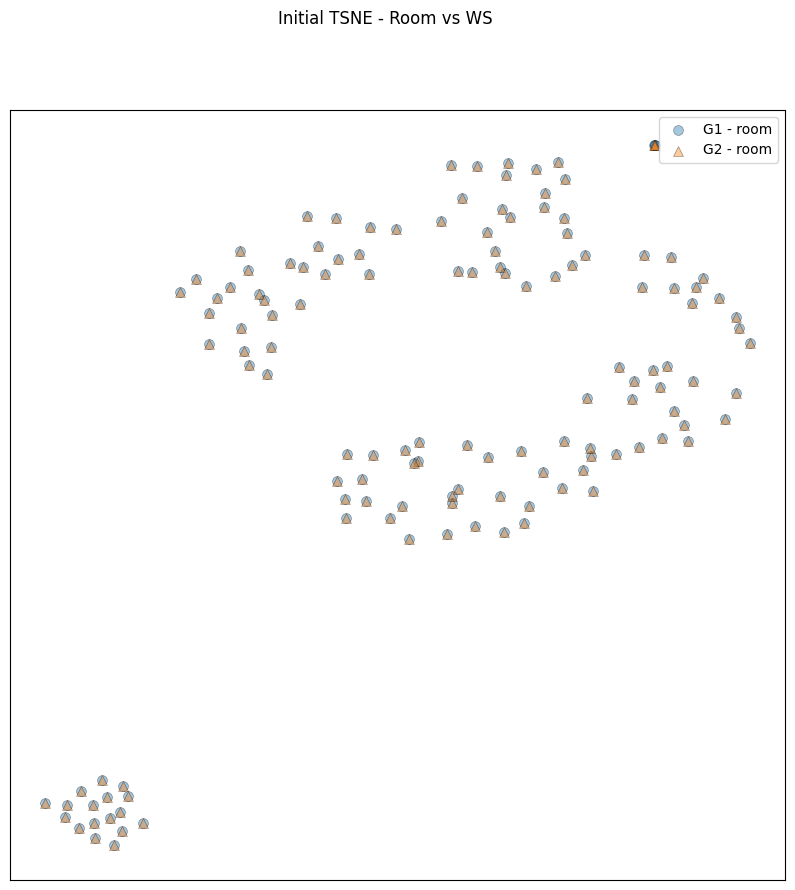

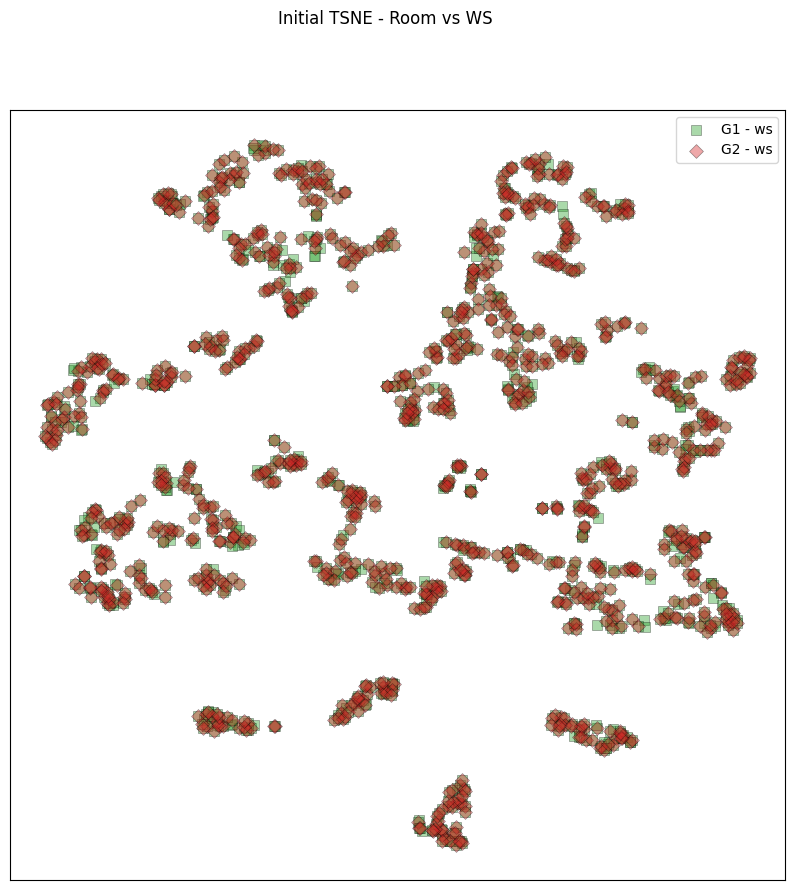

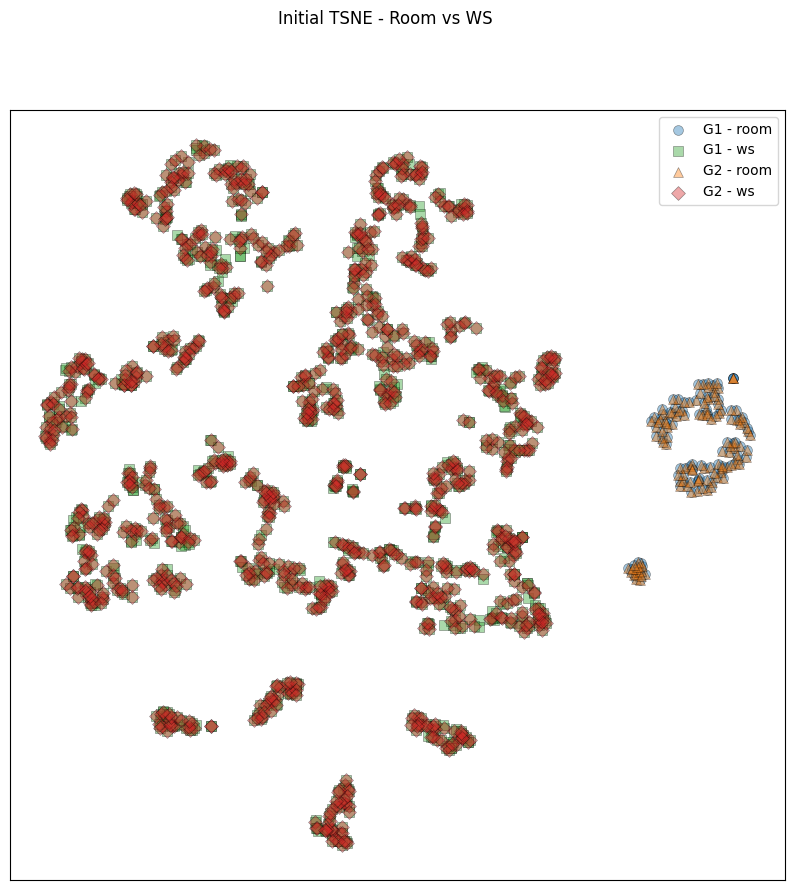

In [50]:
# visualize initial validation embeddings
batch = next(iter(test_loader))
h1_test, h2_test = batch[0], batch[1]
visualize_initial_embeddings(h1_test.x, h2_test.x, title="Initial TSNE - Room vs WS", node_type_filter="room")
visualize_initial_embeddings(h1_test.x, h2_test.x, title="Initial TSNE - Room vs WS", node_type_filter="ws")
visualize_initial_embeddings(h1_test.x, h2_test.x, title="Initial TSNE - Room vs WS")

In [ ]:
train_losses, val_losses, val_embeddings_history = train_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    writer=writer,
    best_model_path=best_val_model_path,
    final_model_path=final_model_path,
    patience=patience,
    resume=False
)

In [ ]:
create_embedding_gif_stride(val_embeddings_history, os.path.join(models_path, "embeddings_evolution.gif"), fps=0.001)

In [ ]:
plot_losses(train_losses, val_losses, os.path.join(models_path, 'losses.png'))

In [ ]:
checkpoint = torch.load(best_val_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.to(device)

# Evaluate on the test set
test_acc, test_loss, test_embeddings = evaluate_sinkhorn(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

inference_times = []
# use the model to predict the matching on a test graph
correct = 0
total_cols = 0

for i, (g1_out, g2_perm, gt_perm) in enumerate(test_list):
    start_time = time.time()
    result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=False)
    end_time = time.time()
    inference_times.append(end_time - start_time)
    errors = (result != gt_perm.to(result.device)).sum().item()
    if errors > 0:
        print(f"Graph {i}: Errors found: {errors}")

    # Accuracy calculation after hungarian
    pred_idx = result.argmax(dim=0)
    target_idx = gt_perm.argmax(dim=0)
    correct += (pred_idx == target_idx).sum().item()
    total_cols += result.shape[1]

accuracy = correct / total_cols if total_cols > 0 else 0.0
print(f"Test Accuracy (after Hungarian): {accuracy:.4f}")

mean_inference_time = np.mean(inference_times)
std_inference_time = np.std(inference_times)
print(f"Inference time: {mean_inference_time:.6f} seconds (mean) ± {std_inference_time:.6f} seconds (std)")

In [ ]:
g1_out, g2_perm, gt_perm = test_list[3]
result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=False)

plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=result,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="wrong",
    path=os.path.join(models_path, "test.png")
)

## Ws dropout noise

In [ ]:
#load preprocessed dataset
gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "equal")
gm_local_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "partial_graph_matching", "ws_dropout_noise")
models_path = os.path.join(GNN_PATH, 'models', "partial_graph_matching", "ws_dropout_noise")

original_graphs = deserialize_graph_matching_dataset(
    gm_equal_preprocessed_path,
    "original.pkl"
)
noise_graphs = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "noise.pkl"
)

train_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "train_dataset.pkl"
)
val_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "valid_dataset.pkl"
)
test_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "test_dataset.pkl"
)

In [ ]:
d1,d2,gt = train_list[0]
print(d1)
print(d2)
print(gt)
print(gt.shape)
plot_two_graphs_with_matching([d1,d2],gt_perm=gt,original_graphs=original_graphs,noise_graphs=noise_graphs,path=os.path.join(models_path, "train.png"))

In [ ]:
train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

In [ ]:
# Percorsi per salvare i modelli
best_val_model_path = os.path.join(models_path, 'best_val_model.pt')
final_model_path = os.path.join(models_path, 'final_model.pt')

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

# Modello e ottimizzatore
model = MatchingModel_GATv2SinkhornTopK(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Logger TensorBoard
writer = setup_tb_logger(
    base_dir="tb_logs",
    model_name=model._get_name(),
    dataset_name="PGM_ws_dropout_noise",
    experiment_name="exp1"
)

#model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

In [ ]:
train_losses, val_losses, val_embeddings_history = train_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    writer=writer,
    best_model_path=best_val_model_path,
    final_model_path=final_model_path,
    patience=patience,
    resume=False
)

In [ ]:
create_embedding_gif_stride(val_embeddings_history, os.path.join(models_path, "embeddings_evolution.gif"), fps=0.001)

In [ ]:
plot_losses(train_losses, val_losses, os.path.join(models_path, 'losses.png'))

In [ ]:
checkpoint = torch.load(best_val_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.to(device)

# Evaluate on the test set
test_acc, test_loss, test_embeddings = evaluate_sinkhorn(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

inference_times = []
# use the model to predict the matching on a test graph
correct = 0
total_cols = 0

for i, (g1_out, g2_perm, gt_perm) in enumerate(test_list):
    start_time = time.time()
    result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=False)
    end_time = time.time()
    inference_times.append(end_time - start_time)
    errors = (result != gt_perm.to(result.device)).sum().item()
    if errors > 0:
        print(f"Graph {i}: Errors found: {errors}")

    # Accuracy calculation after hungarian
    pred_idx = result.argmax(dim=0)
    target_idx = gt_perm.argmax(dim=0)
    correct += (pred_idx == target_idx).sum().item()
    total_cols += result.shape[1]

accuracy = correct / total_cols if total_cols > 0 else 0.0
print(f"Test Accuracy (after Hungarian): {accuracy:.4f}")

mean_inference_time = np.mean(inference_times)
std_inference_time = np.std(inference_times)
print(f"Inference time: {mean_inference_time:.6f} seconds (mean) ± {std_inference_time:.6f} seconds (std)")

In [ ]:
g1_out, g2_perm, gt_perm = test_list[3]
result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=False)

plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=result,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="wrong",
    path=os.path.join(models_path, "test.png")
)

## Room dropout equal

In [ ]:
#load preprocessed dataset
gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "equal")
gm_local_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "partial_graph_matching", "room_dropout_equal")
models_path = os.path.join(GNN_PATH, 'models', "partial_graph_matching", "room_dropout_equal")

original_graphs = deserialize_graph_matching_dataset(
    gm_equal_preprocessed_path,
    "original.pkl"
)
noise_graphs = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "noise.pkl"
)

train_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "train_dataset.pkl"
)
val_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "valid_dataset.pkl"
)
test_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "test_dataset.pkl"
)

In [ ]:
d1,d2,gt = train_list[0]
print(d1)
print(d2)
print(gt)
print(gt.shape)
plot_two_graphs_with_matching([d1,d2],gt_perm=gt,original_graphs=original_graphs,noise_graphs=noise_graphs,path=os.path.join(models_path, "train.png"))

In [ ]:
train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

In [ ]:
# Percorsi per salvare i modelli
best_val_model_path = os.path.join(models_path, 'best_val_model.pt')
final_model_path = os.path.join(models_path, 'final_model.pt')

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

# Modello e ottimizzatore
model = MatchingModel_GATv2SinkhornTopK(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Logger TensorBoard
writer = setup_tb_logger(
    base_dir="tb_logs",
    model_name=model._get_name(),
    dataset_name="PGM_room_dropout_equal",
    experiment_name="exp1"
)

#model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

In [ ]:
train_losses, val_losses, val_embeddings_history = train_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    writer=writer,
    best_model_path=best_val_model_path,
    final_model_path=final_model_path,
    patience=patience,
    resume=False
)

In [ ]:
create_embedding_gif_stride(val_embeddings_history, os.path.join(models_path, "embeddings_evolution.gif"), fps=0.001)

In [ ]:
plot_losses(train_losses, val_losses, os.path.join(models_path, 'losses.png'))

In [ ]:
checkpoint = torch.load(best_val_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.to(device)

# Evaluate on the test set
test_acc, test_loss, test_embeddings = evaluate_sinkhorn(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

inference_times = []
# use the model to predict the matching on a test graph
correct = 0
total_cols = 0

for i, (g1_out, g2_perm, gt_perm) in enumerate(test_list):
    start_time = time.time()
    result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=False)
    end_time = time.time()
    inference_times.append(end_time - start_time)
    errors = (result != gt_perm.to(result.device)).sum().item()
    if errors > 0:
        print(f"Graph {i}: Errors found: {errors}")

    # Accuracy calculation after hungarian
    pred_idx = result.argmax(dim=0)
    target_idx = gt_perm.argmax(dim=0)
    correct += (pred_idx == target_idx).sum().item()
    total_cols += result.shape[1]

accuracy = correct / total_cols if total_cols > 0 else 0.0
print(f"Test Accuracy (after Hungarian): {accuracy:.4f}")

mean_inference_time = np.mean(inference_times)
std_inference_time = np.std(inference_times)
print(f"Inference time: {mean_inference_time:.6f} seconds (mean) ± {std_inference_time:.6f} seconds (std)")

In [ ]:
g1_out, g2_perm, gt_perm = test_list[3]
result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=False)

plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=result,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="wrong",
    path=os.path.join(models_path, "test.png")
)

## Room dropout noise

In [ ]:
#load preprocessed dataset
gm_equal_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "graph_matching", "equal")
gm_local_preprocessed_path = os.path.join(GNN_PATH, "preprocessed", "partial_graph_matching", "room_dropout_noise")
models_path = os.path.join(GNN_PATH, 'models', "partial_graph_matching", "room_dropout_noise")

original_graphs = deserialize_graph_matching_dataset(
    gm_equal_preprocessed_path,
    "original.pkl"
)
noise_graphs = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "noise.pkl"
)

train_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "train_dataset.pkl"
)
val_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "valid_dataset.pkl"
)
test_list = deserialize_graph_matching_dataset(
    gm_local_preprocessed_path,
    "test_dataset.pkl"
)

In [ ]:
d1,d2,gt = train_list[0]
print(d1)
print(d2)
print(gt)
print(gt.shape)
plot_two_graphs_with_matching([d1,d2],gt_perm=gt,original_graphs=original_graphs,noise_graphs=noise_graphs,path=os.path.join(models_path, "train.png"))

In [ ]:
train_dataset = GraphMatchingDataset(train_list)
val_dataset = GraphMatchingDataset(val_list)
test_dataset = GraphMatchingDataset(test_list)

In [ ]:
# Percorsi per salvare i modelli
best_val_model_path = os.path.join(models_path, 'best_val_model.pt')
final_model_path = os.path.join(models_path, 'final_model.pt')

# Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_pyg_matching, generator=g)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_pyg_matching)

# Modello e ottimizzatore
model = MatchingModel_GATv2SinkhornTopK(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Logger TensorBoard
writer = setup_tb_logger(
    base_dir="tb_logs",
    model_name=model._get_name(),
    dataset_name="PGM_room_dropout_noise",
    experiment_name="exp1"
)

#model summary
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

In [ ]:
train_losses, val_losses, val_embeddings_history = train_loop(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    writer=writer,
    best_model_path=best_val_model_path,
    final_model_path=final_model_path,
    patience=patience,
    resume=False
)

In [ ]:
create_embedding_gif_stride(val_embeddings_history, os.path.join(models_path, "embeddings_evolution.gif"), fps=0.001)

In [ ]:
plot_losses(train_losses, val_losses, os.path.join(models_path, 'losses.png'))

In [ ]:
checkpoint = torch.load(best_val_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.to(device)

# Evaluate on the test set
test_acc, test_loss, test_embeddings = evaluate_sinkhorn(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

inference_times = []
# use the model to predict the matching on a test graph
correct = 0
total_cols = 0

for i, (g1_out, g2_perm, gt_perm) in enumerate(test_list):
    start_time = time.time()
    result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=False)
    end_time = time.time()
    inference_times.append(end_time - start_time)
    errors = (result != gt_perm.to(result.device)).sum().item()
    if errors > 0:
        print(f"Graph {i}: Errors found: {errors}")

    # Accuracy calculation after hungarian
    pred_idx = result.argmax(dim=0)
    target_idx = gt_perm.argmax(dim=0)
    correct += (pred_idx == target_idx).sum().item()
    total_cols += result.shape[1]

accuracy = correct / total_cols if total_cols > 0 else 0.0
print(f"Test Accuracy (after Hungarian): {accuracy:.4f}")

mean_inference_time = np.mean(inference_times)
std_inference_time = np.std(inference_times)
print(f"Inference time: {mean_inference_time:.6f} seconds (mean) ± {std_inference_time:.6f} seconds (std)")

In [ ]:
g1_out, g2_perm, gt_perm = test_list[3]
result = predict_matching_matrix(model, g1_out, g2_perm, use_hungarian=False)

plot_two_graphs_with_matching(
    [g1_out, g2_perm],
    gt_perm=gt_perm,
    pred_perm=result,
    original_graphs=original_graphs,
    noise_graphs=noise_graphs,
    viz_rooms=True,
    viz_ws=True,
    match_display="wrong",
    path=os.path.join(models_path, "test.png")
)